In [2]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action="ignore")
pd.set_option('display.max_columns', None)
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import OneHotEncoder
from sklearn.utils import resample
from sklearn.impute import KNNImputer
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, BaggingClassifier, VotingClassifier, HistGradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score

In [2]:
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'Malgun Gothic' # 예시: 맑은 고딕으로 설정 (Windows 환경 시)
plt.rcParams['axes.unicode_minus'] = False

In [12]:
df = pd.read_csv("건강데이터_2022_2023_합본.csv")
df.columns

Index(['ID', 'year', 'region', 'town_t', 'sex', 'age', 'incm', 'ho_incm',
       'edu', 'occp', 'cfam', 'genertn', 'D_1_1', 'DI1_dg', 'DI1_ag', 'DI1_pr',
       'DI1_pt', 'DI1_2', 'DI2_dg', 'DI2_ag', 'DI2_pr', 'DI2_pt', 'DI2_2',
       'DE1_dg', 'DE1_ag', 'DE1_pr', 'DE1_pt', 'DE1_3', 'DE1_31', 'DE1_32',
       'DE1_33', 'DE1_34', 'DE1_4', 'DN1_dg', 'DN1_ag', 'BH1', 'BO1', 'BO1_1',
       'BO2_1', 'BD1', 'BD1_11', 'BD2_1', 'BP16_1', 'BP16_2', 'BP1', 'BP5',
       'BS1_1', 'BS3_1', 'BS3_2', 'BS12_37', 'BS12_47', 'BS12_47_1', 'BS12_1',
       'BS12_2', 'BE3_31', 'BE3_32', 'BE3_33', 'BE5_1', 'BE9', 'HE_fh',
       'HE_HPfh1', 'HE_HPfh2', 'HE_HLfh1', 'HE_HLfh2', 'HE_DMfh1', 'HE_DMfh2',
       'HE_sbp1', 'HE_dbp1', 'HE_sbp2', 'HE_dbp2', 'HE_HP', 'HE_ht', 'HE_wt',
       'HE_wc', 'HE_BMI', 'HE_obe', 'HE_glu', 'HE_HbA1c', 'HE_DM_HbA1c',
       'HE_chol', 'HE_HDL_st2', 'HE_TG', 'HE_LDL_drct', 'HE_HCHOL', 'HE_HTG',
       'HE_ast', 'HE_alt', 'HE_BUN', 'HE_crea', 'HE_Upro', 'HE_Ucrea',
       'HE

전처리 

In [13]:
df['BE5_1'] = df['BE5_1'].astype(str).str.strip().replace({ #1주일 간 근력운동 일수
'1.0' : 0,
'2.0' : 1,
'3.0' : 2,
'4.0' : 3,
'5.0' : 4,
'6.0' : 5,
'8.0' : 0,
'9.0' : np.nan,
'nan' : np.nan
 })
df['BE5_1'] = pd.to_numeric(df['BE5_1'], errors='coerce')

In [14]:
df['LS_VEG1'] = df['LS_VEG1'].astype(str).str.strip().replace({  #최근 1년 동안 평균 채소류(김치 및 장아찌 제외), 버섯류, 해조류 섭취 빈도
'1.0' : 1095,
'2.0' : 730,
'3.0' : 365,
'4.0' : 286,
'5.0' : 156,
'6.0' : 52,
'7.0' : 30,
'8.0' : 12,
'9.0' : 6,
'99.0': np.nan,
'nan' : np.nan
})
df['LS_VEG1'] = pd.to_numeric(df['LS_VEG1'], errors='coerce')

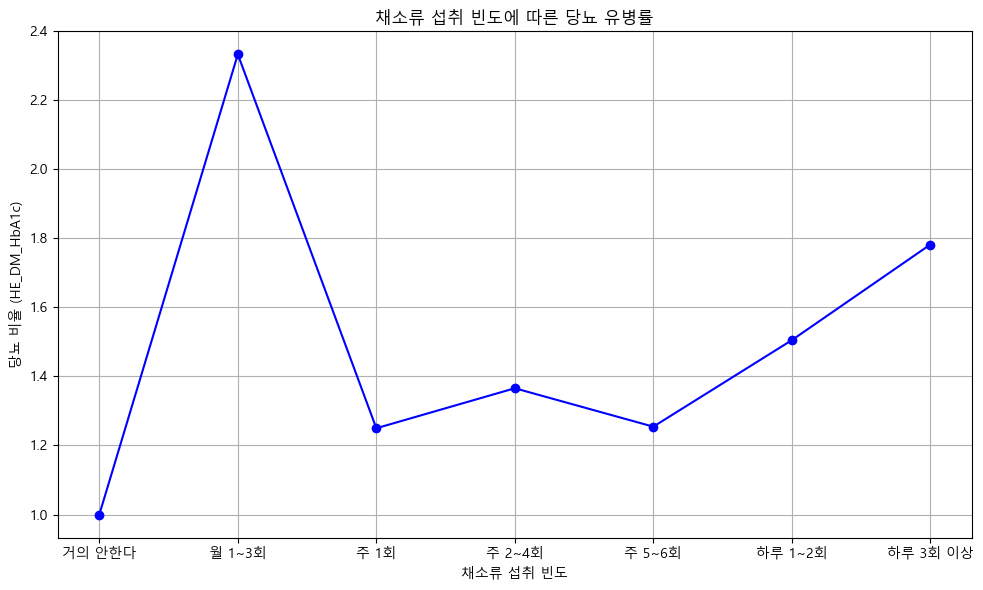

In [ ]:
# LS_VEG1 그룹화 
def map_strength_exercise(val):
    if val == 1:
        return '하루 3회 이상'
    elif val in [2, 3]:
        return '하루 1~2회'
    elif val == 4:
        return '주 5~6회'
    elif val == 5:
        return '주 2~4회'
    elif val == 6:
        return '주 1회'
    elif val in [7, 8]:
        return '월 1~3회'
    elif val == 9:
        return '거의 안한다'
    
df['LS_VEG1_GROUP'] = df['LS_VEG1'].apply(map_strength_exercise)

group_stats = df.groupby('LS_VEG1_GROUP')['HE_DM_HbA1c'].mean().reset_index()
# 선 그래프 시각화
plt.figure(figsize=(10, 6))
plt.plot(group_stats['LS_VEG1_GROUP'], group_stats['HE_DM_HbA1c'], marker='o', color='blue')
plt.xlabel('채소류 섭취 빈도')
plt.ylabel('당뇨 비율 (HE_DM_HbA1c)')
plt.title('채소류 섭취 빈도에 따른 당뇨 유병률')
plt.grid(True)
plt.tight_layout()
plt.show()

In [15]:
# 일반 담배 하루 평균 흡연량 처리
df['BS3_2'] = df['BS3_2'].replace(888, 0)

# 전자 담배 하루 평균 흡연량 처리
df['BS12_47_1'] = df['BS12_47_1'].replace({888: 0, 999: np.nan}) 

# 합치기 전 숫자형으로 변환
df['BS3_2'] = pd.to_numeric(df['BS3_2'], errors='coerce')
df['BS12_47_1'] = pd.to_numeric(df['BS12_47_1'], errors='coerce')

# 두 변수 합산 (NaN은 무시하고 합함)
df['tobacco'] = df[['BS3_2', 'BS12_47_1']].sum(axis=1, skipna=True)

df['tobacco'] = df['tobacco'].astype(str).str.strip().replace({  
'999.0': np.nan,
})

df['tobacco'] = pd.to_numeric(df['tobacco'], errors='coerce')

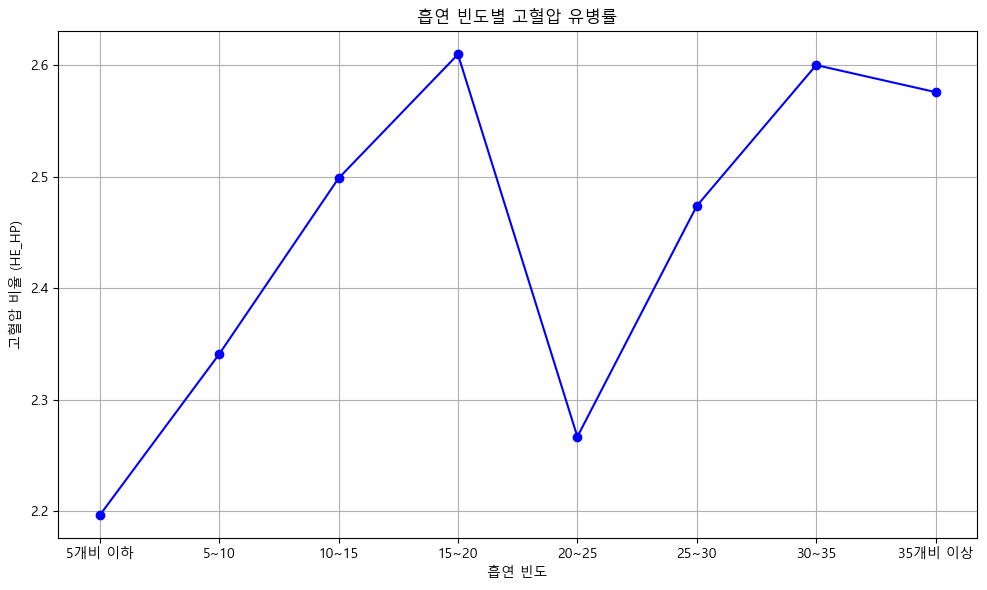

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
# 1. 나이 그룹 생성 (AGE_GROUP 컬럼 추가)
bins = [0, 5, 10, 15, 20, 25, 30, 35, 40]  # 80세 이상 포함
labels = ['5개비 이하', '5~10', '10~15', '15~20', '20~25', '25~30', '30~35', '35개비 이상']

df['tobacco_GROUP'] = pd.cut(df['tobacco'], bins=bins, labels=labels, right=True)
# 2. 나이그룹별 당뇨병 평균값(= 유병률) 계산
group_stats = df.groupby('tobacco_GROUP')['HE_HP'].mean().reset_index()
# 3. 시각화
plt.figure(figsize=(10, 6))
plt.plot(group_stats['tobacco_GROUP'], group_stats['HE_HP'], marker='o', color='blue')
plt.xlabel('흡연 빈도')
plt.ylabel('고혈압 비율 (HE_HP)')
plt.title('흡연 빈도별 고혈압 유병률')
plt.grid(True)
plt.tight_layout()
plt.show()

In [16]:
df['BD1_11'] = df['BD1_11'].astype(str).str.strip().replace({ #1년간 음주빈도
'1.0' : 0,
'2.0' : 6,
'3.0' : 12,
'4.0' : 42,
'5.0' : 130,
'6.0' : 286,
'8.0' : 0,
'9.0' : np.nan,
'nan' : np.nan
})
df['BD1_11'] = pd.to_numeric(df['BD1_11'], errors='coerce')

In [19]:
import pandas as pd #고혈압 파생변수 

def classify_bp(row):
    sbp = row['HE_sbp1']
    dbp = row['HE_dbp1']

    if sbp >= 140 or dbp >= 90:
        return '4'
    elif 130 <= sbp <= 139 or 80 <= dbp <= 89:
        return '3'
    elif 120 <= sbp <= 129 and dbp < 80:
        return '2'
    else:
        return '1'

# 데이터프레임에 새로운 열 추가
df['HE_HP2'] = df.apply(classify_bp, axis=1)
df['HE_HP2'] = pd.to_numeric(df['HE_HP2'], errors='coerce')


In [27]:
df['HE_HP2']

0        4
1        4
2        1
3        3
4        4
        ..
13189    1
13190    3
13191    3
13192    4
13193    3
Name: HE_HP2, Length: 13194, dtype: int64

In [28]:
df['HE_HP']

0        4.0
1        3.0
2        1.0
3        2.0
4        3.0
        ... 
13189    4.0
13190    4.0
13191    3.0
13192    3.0
13193    3.0
Name: HE_HP, Length: 13194, dtype: float64

Matplotlib 'NanumGothic' font set for Korean display.
--- Visualizing Data Distribution (Histograms) ---
Plotting histogram for 'BE5_1' (1주일 간 운동 횟수)...
Plotting histogram for 'LS_VEG1' (1년 동안 평균 채소류 섭취 빈도)...
Plotting histogram for 'tobacco' (하루평균 흡연량)...
Plotting histogram for 'BD1_11' (1년 간 음주 빈도)...


C:\Users\82104\AppData\Local\Temp\ipykernel_33852\1966733224.py:105: UserWarning: Glyph 51452 (\N{HANGUL SYLLABLE JU}) missing from font(s) Arial.
  plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # 전체 제목 공간 확보를 위해 레이아웃 조정
C:\Users\82104\AppData\Local\Temp\ipykernel_33852\1966733224.py:105: UserWarning: Glyph 51068 (\N{HANGUL SYLLABLE IL}) missing from font(s) Arial.
  plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # 전체 제목 공간 확보를 위해 레이아웃 조정
C:\Users\82104\AppData\Local\Temp\ipykernel_33852\1966733224.py:105: UserWarning: Glyph 44036 (\N{HANGUL SYLLABLE GAN}) missing from font(s) Arial.
  plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # 전체 제목 공간 확보를 위해 레이아웃 조정
C:\Users\82104\AppData\Local\Temp\ipykernel_33852\1966733224.py:105: UserWarning: Glyph 50868 (\N{HANGUL SYLLABLE UN}) missing from font(s) Arial.
  plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # 전체 제목 공간 확보를 위해 레이아웃 조정
C:\Users\82104\AppData\Local\Temp\ipykernel_33852\1966733224.py:105: UserWarning: Glyph 46041 (\N{HANGUL SYLLABLE DONG}) missing fr

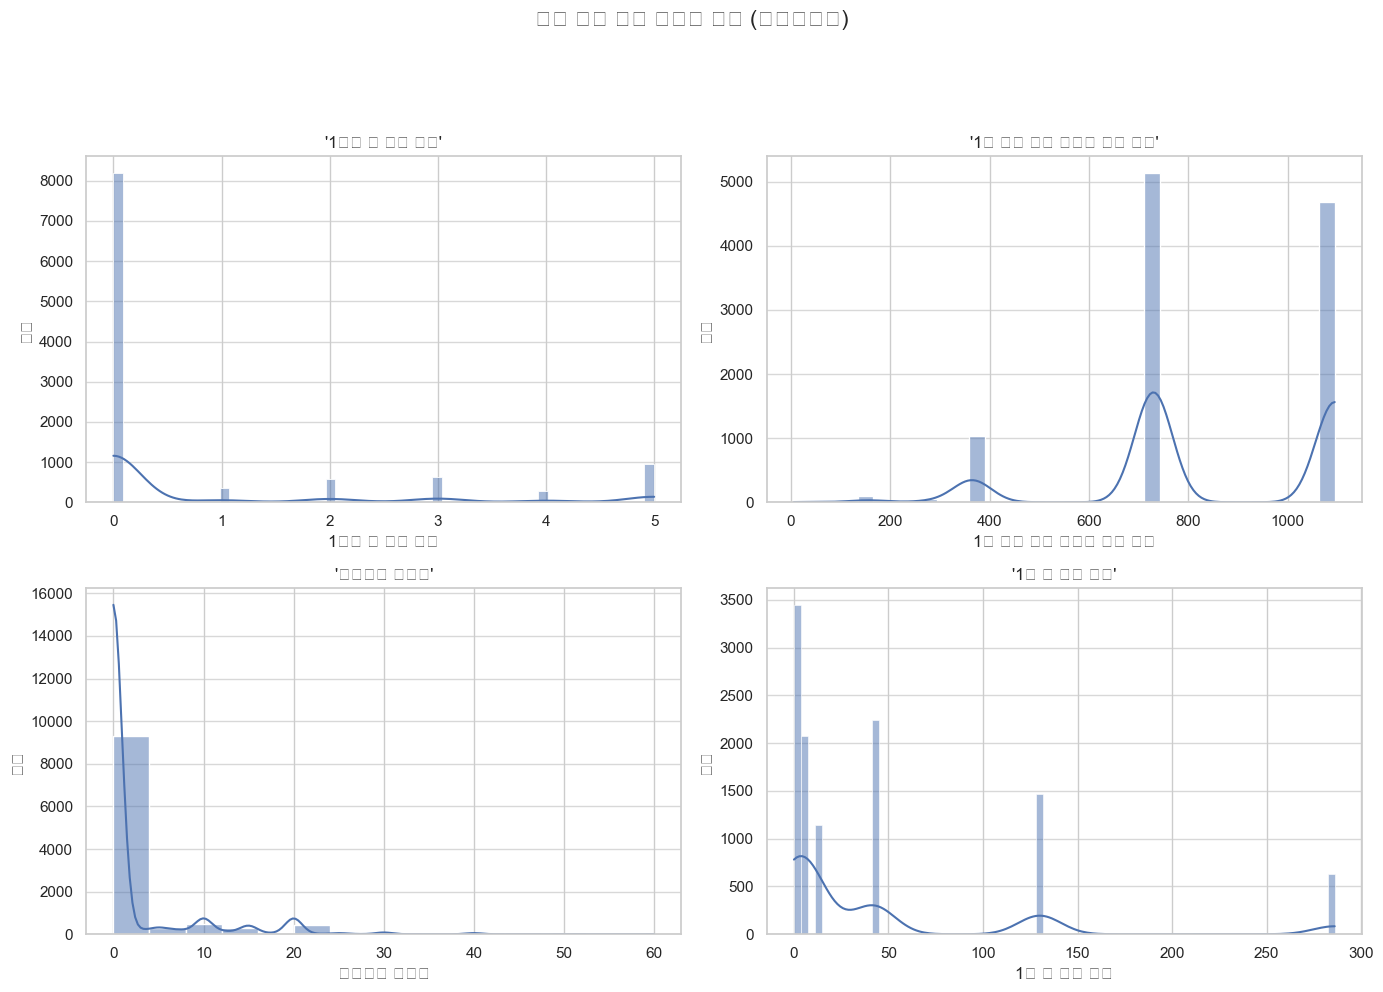


--- Visualization Complete ---


In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.font_manager as fm # Import font_manager

# --- Matplotlib에서 한글 출력을 위한 설정 ---
# 설치된 나눔 글꼴 중 하나를 사용합니다. 시스템에 따라 경로 또는 이름이 다를 수 있습니다.
# 만약 나눔 글꼴이 없다면 다른 한글 지원 글꼴 (예: Malgun Gothic)을 사용하거나 설치해야 합니다.
try:
    plt.rcParams['font.family'] = 'NanumGothic' # 예시: 나눔고딕
    plt.rcParams['axes.unicode_minus'] = False # 마이너스 기호 깨짐 방지
    print("Matplotlib 'NanumGothic' font set for Korean display.")
except Exception as e:
    print(f"Warning: Could not set NanumGothic font. Korean characters might not display correctly: {e}")
    print("Please install a Korean font (e.g., NanumGothic) and ensure matplotlib can find it.")
    # 대체 글꼴 설정 시도 (예: Windows의 경우 Malgun Gothic)
    try:
        plt.rcParams['font.family'] = 'Malgun Gothic'
        plt.rcParams['axes.unicode_minus'] = False
        print("Matplotlib 'Malgun Gothic' font set for Korean display as fallback.")
    except Exception as e2:
        print(f"Warning: Could not set Malgun Gothic font either: {e2}")

# --- 사용 가능한 글꼴 목록 출력 (디버깅용) ---
# 이 코드를 실행하여 시스템에서 Matplotlib가 인식하는 글꼴 목록을 확인하고
# 적절한 한글 글꼴 이름을 찾아 위 font.family 설정에 사용하세요.
# Google Colab에서 폰트 설치 후 런타임 재시작해야 정확한 목록이 나옵니다.
# print("\n--- Available Fonts (Partial List) ---")
# font_list_debug = [font.name for font in fm.fontManager.ttflist]
# print(font_list_debug[:30]) # 처음 30개만 출력
# print("--------------------------------------\n")


# 시각화 스타일 설정
sns.set(style="whitegrid")

# Assume df_clustering is already loaded and available
# 예시 데이터프레임 생성 (실제 데이터로 대체해야 합니다)
# 데이터 분포 시각화를 위해 실제 데이터의 일부 특성을 반영하여 예시 데이터를 생성합니다.
# 실제 df_clustering 변수에 데이터가 로드되어 있다면 아래 예시 데이터 생성 코드는 주석 처리하거나 삭제하세요.
# np.random.seed(42) # 재현성을 위해 시드 설정
# n_samples = 1000
# df_clustering = pd.DataFrame({
#     'BE5_1': np.random.poisson(1, n_samples) + np.random.rand(n_samples) * 0.5, # 운동 횟수 (작은 값에 집중)
#     'LS_VEG1': np.random.normal(700, 150, n_samples), # 채소 섭취 빈도 (정규 분포 형태)
#     'tobacco': np.random.gamma(1, 5, n_samples), # 흡연량 (0에 집중되고 긴 꼬리)
#     'BD1_11': np.random.gamma(2, 30, n_samples) + np.random.randint(0, 5, n_samples) * 50 # 음주 빈도 (0에 집중되고 드문 높은 값)
# })
# # 실제 데이터 범위에 맞게 이상치 추가 (예시)
# df_clustering.loc[np.random.choice(df_clustering.index, 20, replace=False), 'tobacco'] = np.random.randint(50, 200, 20)
# df_clustering.loc[np.random.choice(df_clustering.index, 10, replace=False), 'BD1_11'] = np.random.randint(300, 500, 10)
# df_clustering['BE5_1'] = np.clip(df_clustering['BE5_1'], 0, None) # 음수 값 방지
# df_clustering['LS_VEG1'] = np.clip(df_clustering['LS_VEG1'], 0, None) # 음수 값 방지


# 데이터 분포를 보고 싶은 열 목록
columns_to_visualize = ['BE5_1', 'LS_VEG1', 'tobacco', 'BD1_11']

# 각 열에 대한 한글 이름 매핑
feature_korean_names = {
    'BE5_1': '1주일 간 운동 횟수',
    'LS_VEG1': '1년 동안 평균 채소류 섭취 빈도',
    'tobacco': '하루평균 흡연량',
    'BD1_11': '1년 간 음주 빈도',
}

print("--- Visualizing Data Distribution (Histograms) ---")

# 2x2 서브플롯 설정
fig, axes = plt.subplots(2, 2, figsize=(14, 10)) # 2행 2열, 전체 그림 크기 설정
axes = axes.flatten() # axes를 1차원 배열로 변환하여 쉽게 접근

for i, col in enumerate(columns_to_visualize):
    if col in df_clustering.columns:
        print(f"Plotting histogram for '{col}' ({feature_korean_names.get(col, col)})...")

        # 해당 열의 데이터 가져오기 (결측치 제외)
        data = df_clustering.dropna(subset=[col])

        if not data.empty:
            # 히스토그램 그리기
            sns.histplot(data=data, x=col, kde=True, ax=axes[i]) # ax=axes[i]로 서브플롯 지정
            axes[i].set_title(f"'{feature_korean_names.get(col, col)}'", size=12) # 서브플롯 제목
            axes[i].set_xlabel(feature_korean_names.get(col, col)) # 서브플롯 x축 라벨
            axes[i].set_ylabel("빈도") # 서브플롯 y축 라벨
            axes[i].grid(axis='y', alpha=0.75)
        else:
            axes[i].set_title(f"'{feature_korean_names.get(col, col)}' (데이터 없음)", size=12)
            axes[i].text(0.5, 0.5, '데이터 없음', horizontalalignment='center', verticalalignment='center', transform=axes[i].transAxes)
            axes[i].set_xlabel(feature_korean_names.get(col, col))
            axes[i].set_ylabel("빈도")


    else:
        print(f"오류: 데이터프레임에 '{col}' 열이 없습니다. 플롯을 건너뜁니다.")
        axes[i].set_title(f"'{feature_korean_names.get(col, col)}' (열 없음)", size=12)
        axes[i].text(0.5, 0.5, '열 없음', horizontalalignment='center', verticalalignment='center', transform=axes[i].transAxes)
        axes[i].set_xlabel(feature_korean_names.get(col, col))
        axes[i].set_ylabel("빈도")


# 전체 플롯 제목 및 레이아웃 조정
fig.suptitle('생활 습관 변수 데이터 분포 (히스토그램)', size=16, y=1.02) # 전체 제목
plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # 전체 제목 공간 확보를 위해 레이아웃 조정
plt.show()

print("\n--- Visualization Complete ---")



Matplotlib 'NanumGothic' font set for Korean display.
--- Generating Correlation Heatmap ---


c:\Users\82104\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\utils.py:61: UserWarning: Glyph 50868 (\N{HANGUL SYLLABLE UN}) missing from font(s) Arial.
  fig.canvas.draw()
c:\Users\82104\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\utils.py:61: UserWarning: Glyph 46041 (\N{HANGUL SYLLABLE DONG}) missing from font(s) Arial.
  fig.canvas.draw()
c:\Users\82104\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\utils.py:61: UserWarning: Glyph 54943 (\N{HANGUL SYLLABLE HOES}) missing from font(s) Arial.
  fig.canvas.draw()
c:\Users\82104\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\utils.py:61: UserWarning: Glyph 49688 (\N{HANGUL SYLLABLE SU}) missing from font(s) Arial.
  fig.canvas.draw()
c:\Users\82104\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\utils.py:61: UserWarning: Glyph 52292 (\N{HANGUL SYLLABLE CAE}) missing from font(s) Arial.
  fig.canvas.draw()
c:\Users\82104\AppData\Local\Progra

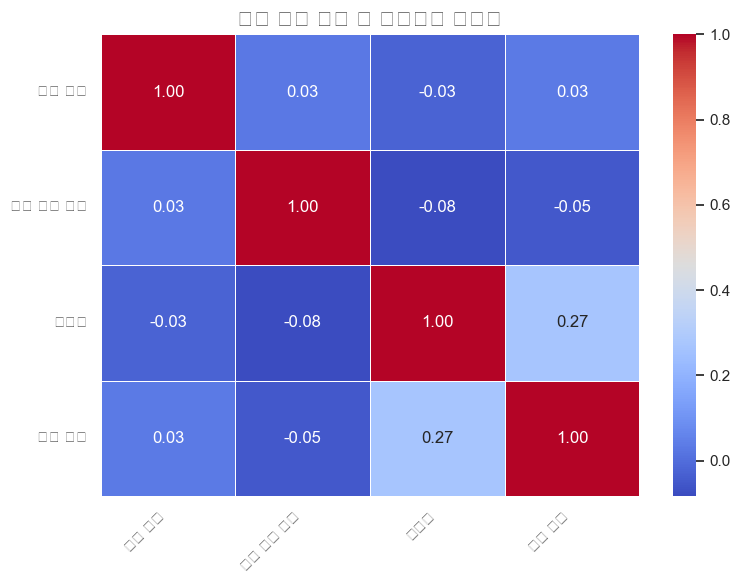


--- Heatmap Generation Complete ---


In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.font_manager as fm # Import font_manager

# --- Matplotlib에서 한글 출력을 위한 설정 ---
# 설치된 나눔 글꼴 중 하나를 사용합니다. 시스템에 따라 경로 또는 이름이 다를 수 있습니다.
# 만약 나눔 글꼴이 없다면 다른 한글 지원 글꼴 (예: Malgun Gothic)을 사용하거나 설치해야 합니다.
try:
    plt.rcParams['font.family'] = 'NanumGothic' # 예시: 나눔고딕
    plt.rcParams['axes.unicode_minus'] = False # 마이너스 기호 깨짐 방지
    print("Matplotlib 'NanumGothic' font set for Korean display.")
except Exception as e:
    print(f"Warning: Could not set NanumGothic font. Korean characters might not display correctly: {e}")
    print("Please install a Korean font (e.g., NanumGothic) and ensure matplotlib can find it.")
    # 대체 글꼴 설정 시도 (예: Windows의 경우 Malgun Gothic)
    try:
        plt.rcParams['font.family'] = 'Malgun Gothic'
        plt.rcParams['axes.unicode_minus'] = False
        print("Matplotlib 'Malgun Gothic' font set for Korean display as fallback.")
    except Exception as e2:
        print(f"Warning: Could not set Malgun Gothic font either: {e2}")

# --- 사용 가능한 글꼴 목록 출력 (디버깅용) ---
# 이 코드를 실행하여 시스템에서 Matplotlib가 인식하는 글꼴 목록을 확인하고
# 적절한 한글 글꼴 이름을 찾아 위 font.family 설정에 사용하세요.
# Google Colab에서 폰트 설치 후 런타임 재시작해야 정확한 목록이 나옵니다.
# print("\n--- Available Fonts (Partial List) ---")
# font_list_debug = [font.name for font in fm.fontManager.ttflist]
# print(font_list_debug[:30]) # 처음 30개만 출력
# print("--------------------------------------\n")


# 시각화 스타일 설정
sns.set(style="whitegrid")

# Assume df_clustering is already loaded and available
# 예시 데이터프레임 생성 (실제 데이터로 대체해야 합니다)
# 실제 df_clustering 변수에 데이터가 로드되어 있다면 아래 예시 데이터 생성 코드는 주석 처리하거나 삭제하세요.
# np.random.seed(42) # 재현성을 위해 시드 설정
# n_samples = 1000
# df_clustering = pd.DataFrame({
#     'BE5_1': np.random.poisson(1, n_samples) + np.random.rand(n_samples) * 0.5,
#     'LS_VEG1': np.random.normal(700, 150, n_samples),
#     'tobacco': np.random.gamma(1, 5, n_samples),
#     'BD1_11': np.random.gamma(2, 30, n_samples) + np.random.randint(0, 5, n_samples) * 50
# })
# df_clustering['BE5_1'] = np.clip(df_clustering['BE5_1'], 0, None)
# df_clustering['LS_VEG1'] = np.clip(df_clustering['LS_VEG1'], 0, None)


# 상관관계를 보고 싶은 열 목록
columns_for_correlation = ['BE5_1', 'LS_VEG1', 'tobacco', 'BD1_11']

# 각 열에 대한 한글 이름 매핑 (히트맵 라벨용)
feature_korean_names_short = {
    'BE5_1': '운동 횟수',
    'LS_VEG1': '채소 섭취 빈도',
    'tobacco': '흡연량',
    'BD1_11': '음주 빈도',
}


print("--- Generating Correlation Heatmap ---")

# 선택된 열만 포함하는 데이터프레임 생성 (결측치 제외)
correlation_df = df_clustering[columns_for_correlation].dropna()

if not correlation_df.empty:
    # 상관 행렬 계산
    correlation_matrix = correlation_df.corr()

    # 한글 라벨로 컬럼 이름 변경
    correlation_matrix = correlation_matrix.rename(columns=feature_korean_names_short, index=feature_korean_names_short)

    # 히트맵 그리기
    plt.figure(figsize=(8, 6)) # 그림 크기 설정
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5) # annot=True로 값 표시, fmt=".2f"로 소수점 둘째자리까지 표시
    plt.title('생활 습관 변수 간 상관관계 히트맵', size=16)
    plt.xticks(rotation=45, ha='right') # x축 라벨 회전
    plt.yticks(rotation=0)
    plt.tight_layout() # 라벨이 잘리지 않도록 레이아웃 조정
    plt.show()

else:
    print("오류: 상관 관계 계산 및 히트맵 생성을 위한 유효한 데이터가 없습니다.")

print("\n--- Heatmap Generation Complete ---")


Matplotlib 'NanumGothic' font set for Korean display.
--- Generating Correlation Heatmap ---


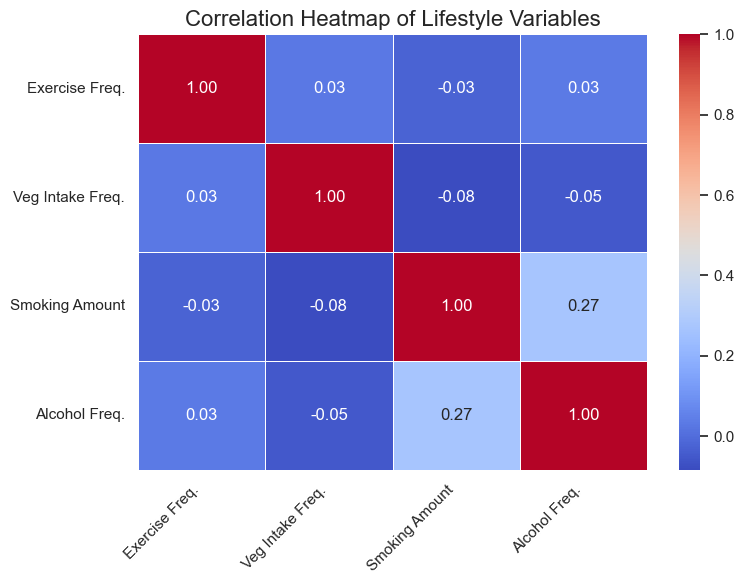


--- Heatmap Generation Complete ---


In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.font_manager as fm # Import font_manager

# --- Matplotlib에서 한글 출력을 위한 설정 ---
# 이 설정은 플롯의 다른 부분 (예: 제목)에 영향을 줄 수 있지만,
# 히트맵 라벨은 이제 영어로 설정됩니다.
try:
    plt.rcParams['font.family'] = 'NanumGothic' # 예시: 나눔고딕
    plt.rcParams['axes.unicode_minus'] = False # 마이너스 기호 깨짐 방지
    print("Matplotlib 'NanumGothic' font set for Korean display.")
except Exception as e:
    print(f"Warning: Could not set NanumGothic font. Korean characters might not display correctly in other plots: {e}")
    print("Please install a Korean font (e.g., NanumGothic) and ensure matplotlib can find it.")
    # 대체 글꼴 설정 시도 (예: Windows의 경우 Malgun Gothic)
    try:
        plt.rcParams['font.family'] = 'Malgun Gothic'
        plt.rcParams['axes.unicode_minus'] = False
        print("Matplotlib 'Malgun Gothic' font set for Korean display as fallback.")
    except Exception as e2:
        print(f"Severe Warning: Error during fallback font setting: {e2}")
        print("Korean characters may not display correctly in other plots.")


# --- 사용 가능한 글꼴 목록 출력 (디버깅용) ---
# 이 코드를 실행하여 시스템에서 Matplotlib가 인식하는 글꼴 목록을 확인하고
# 적절한 한글 글꼴 이름을 찾아 위 font.family 설정에 사용하세요.
# Google Colab에서 폰트 설치 후 런타임 재시작해야 정확한 목록이 나옵니다.
# print("\n--- Available Fonts (Partial List) ---")
# font_list_debug = [font.name for font in fm.fontManager.ttflist]
# print(font_list_debug[:30]) # 처음 30개만 출력
# print("--------------------------------------\n")


# 시각화 스타일 설정
sns.set(style="whitegrid")

# Assume df_clustering is already loaded and available
# 예시 데이터프레임 생성 (실제 데이터로 대체해야 합니다)
# 실제 df_clustering 변수에 데이터가 로드되어 있다면 아래 예시 데이터 생성 코드는 주석 처리하거나 삭제하세요.
# np.random.seed(42) # 재현성을 위해 시드 설정
# n_samples = 1000
# df_clustering = pd.DataFrame({
#     'BE5_1': np.random.poisson(1, n_samples) + np.random.rand(n_samples) * 0.5,
#     'LS_VEG1': np.random.normal(700, 150, n_samples),
#     'tobacco': np.random.gamma(1, 5, n_samples),
#     'BD1_11': np.random.gamma(2, 30, n_samples) + np.random.randint(0, 5, n_samples) * 50
# })
# df_clustering['BE5_1'] = np.clip(df_clustering['BE5_1'], 0, None)
# df_clustering['LS_VEG1'] = np.clip(df_clustering['LS_VEG1'], 0, None)


# 상관관계를 보고 싶은 열 목록
columns_for_correlation = ['BE5_1', 'LS_VEG1', 'tobacco', 'BD1_11']

# 각 열에 대한 영어 이름 매핑 (히트맵 라벨용)
feature_english_names_short = {
    'BE5_1': 'Exercise Freq.',
    'LS_VEG1': 'Veg Intake Freq.',
    'tobacco': 'Smoking Amount',
    'BD1_11': 'Alcohol Freq.',
}


print("--- Generating Correlation Heatmap ---")

# 선택된 열만 포함하는 데이터프레임 생성 (결측치 제외)
correlation_df = df_clustering[columns_for_correlation].dropna()

if not correlation_df.empty:
    # 상관 행렬 계산
    correlation_matrix = correlation_df.corr()

    # 영어 라벨로 컬럼 이름 변경
    correlation_matrix = correlation_matrix.rename(columns=feature_english_names_short, index=feature_english_names_short)

    # 히트맵 그리기
    plt.figure(figsize=(8, 6)) # 그림 크기 설정
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5) # annot=True로 값 표시, fmt=".2f"로 소수점 둘째자리까지 표시
    plt.title('Correlation Heatmap of Lifestyle Variables', size=16) # 제목도 영어로 변경
    plt.xticks(rotation=45, ha='right') # x축 라벨 회전
    plt.yticks(rotation=0)
    plt.tight_layout() # 라벨이 잘리지 않도록 레이아웃 조정
    plt.show()

else:
    print("Error: No valid data available for correlation calculation and heatmap generation.") # 메시지도 영어로 변경

print("\n--- Heatmap Generation Complete ---")


고혈압 

In [20]:
# HE_HP 결측치 행 제거
df_clustering = df.dropna(subset=['HE_HP2'])

columns_to_drop = ['occp', 'HE_Ualb', 'HE_HTG', 'HE_HCHOL', 'HE_fh', 'HE_DMfh1', 'HE_DMfh2',
                   'HE_HPfh1', 'HE_HPfh2', 'HE_HLfh1', 'HE_HLfh2']
df_clustering = df_clustering.drop(columns=columns_to_drop, errors='ignore')

low_missing_columns = [
    'BE5_1','BD1_11', 'LS_VEG1', 'tobacco'
]

In [21]:
# 이전에 low_missing_columns, df_clustering가 정의되었다고 가정합니다.

low_missing_columns = [
 'BE5_1','BD1_11', 'LS_VEG1', 'tobacco'
]

print("--- Checking and filling NaNs ---")
print("Initial NaN count for specified columns:")
print(df_clustering[low_missing_columns].isnull().sum())
print("-" * 30)

# NaN을 각 컬럼의 최빈값으로 df_clustering에서 대체
for col in low_missing_columns:
    print(f"\nProcessing column: '{col}'")
    if col not in df_clustering.columns:
        print(f"Warning: Column '{col}' not found in the DataFrame.")
        continue # 다음 컬럼으로 넘어감

    initial_nan_count = df_clustering[col].isnull().sum()
    print(f"  NaN count before filling: {initial_nan_count}")

    mode_value = df_clustering[col].mode(dropna=True)

    if not mode_value.empty:
        fill_value = mode_value[0]
        print(f"  Calculated mode value: {fill_value} (Type: {type(fill_value)})")

        # 실제로 NaN이 있는 경우에만 fillna 시도
        if initial_nan_count > 0:
             df_clustering[col].fillna(fill_value, inplace=True)
             print(f"  Filled {initial_nan_count} NaN values with {fill_value}.")
        else:
             print(f"  No NaN values found to fill in '{col}'.")

        final_nan_count = df_clustering[col].isnull().sum()
        print(f"  NaN count after filling: {final_nan_count}")

        # 만약 final_nan_count가 0이 아니라면, 채워지지 않은 NaN이 있다는 뜻
        if final_nan_count > 0:
            print(f"  Note: {final_nan_count} NaN values remain in '{col}'. They might not be standard np.nan.")

    else:
        print(f"  Could not determine mode for '{col}' (column might be all NaNs or empty after dropna). No filling performed.")
        print(f"  NaN count after check: {df_clustering[col].isnull().sum()}")


print("\n--- Filling process finished ---")
print("Final NaN count for specified columns:")
print(df_clustering[low_missing_columns].isnull().sum())

# 추가 확인: NaN이 아닌 다른 형태의 누락된 값 확인 (예: 빈 문자열 '')
print("\n--- Checking for other potential missing value representations ---")
for col in low_missing_columns:
     if df_clustering[col].dtype == 'object': # 문자열 타입 컬럼인 경우
         print(f"Checking column '{col}' (object dtype):")
         # 빈 문자열 또는 'NA' 등 의심스러운 값의 개수를 세어봅니다.
         print(f"  Count of empty strings (''): {df_clustering[col].eq('').sum()}")
         # 다른 일반적이지 않은 값들을 value_counts로 확인
         print("  Top values (including non-standard):")
         print(df_clustering[col].value_counts(dropna=False).head()) # dropna=False 포함

--- Checking and filling NaNs ---
Initial NaN count for specified columns:
BE5_1      960
BD1_11     206
LS_VEG1    569
tobacco    210
dtype: int64
------------------------------

Processing column: 'BE5_1'
  NaN count before filling: 960
  Calculated mode value: 0.0 (Type: <class 'numpy.float64'>)
  Filled 960 NaN values with 0.0.
  NaN count after filling: 0

Processing column: 'BD1_11'
  NaN count before filling: 206
  Calculated mode value: 0.0 (Type: <class 'numpy.float64'>)
  Filled 206 NaN values with 0.0.
  NaN count after filling: 0

Processing column: 'LS_VEG1'
  NaN count before filling: 569
  Calculated mode value: 730.0 (Type: <class 'numpy.float64'>)
  Filled 569 NaN values with 730.0.
  NaN count after filling: 0

Processing column: 'tobacco'
  NaN count before filling: 210
  Calculated mode value: 0.0 (Type: <class 'numpy.float64'>)
  Filled 210 NaN values with 0.0.
  NaN count after filling: 0

--- Filling process finished ---
Final NaN count for specified columns:
BE5

In [31]:
knn_columns = [
    'HE_sbp1', 'HE_dbp1', 'HE_wc', 'HE_glu',
    'HE_chol', 'HE_HDL_st2', 'HE_LDL_drct', 'HE_crea',
    'HE_ast', 'HE_alt', 'HE_wt', 'HE_ht', 'HE_BMI'
]

from sklearn.impute import KNNImputer

# HE_HP별로 데이터 분리 및 KNN Imputation
for hp_value in [1, 2, 3, 4]:
    # HE_HP 값에 해당하는 데이터 추출
    hp_df = df_clustering[df_clustering['HE_HP2'] == hp_value][knn_columns].copy()
    if not hp_df.empty:
        # 비해당/모름 값 NaN으로 변환
        hp_df = hp_df.replace([888, 999], np.nan)
        # KNN Imputation
        imputer = KNNImputer(n_neighbors=5, weights="uniform")
        hp_imputed = imputer.fit_transform(hp_df)
        hp_imputed_df = pd.DataFrame(hp_imputed, columns=knn_columns, index=hp_df.index)
        # 원본 데이터에 반영
        df_clustering.loc[hp_df.index, knn_columns] = hp_imputed_df


엘보우 + 평균 실루엣 점수 시각화 


--- Processing HE_HP2 = 1 ---


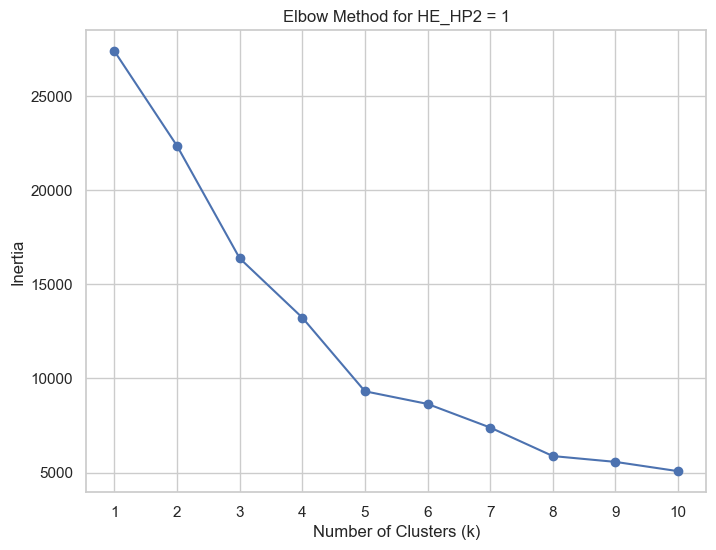

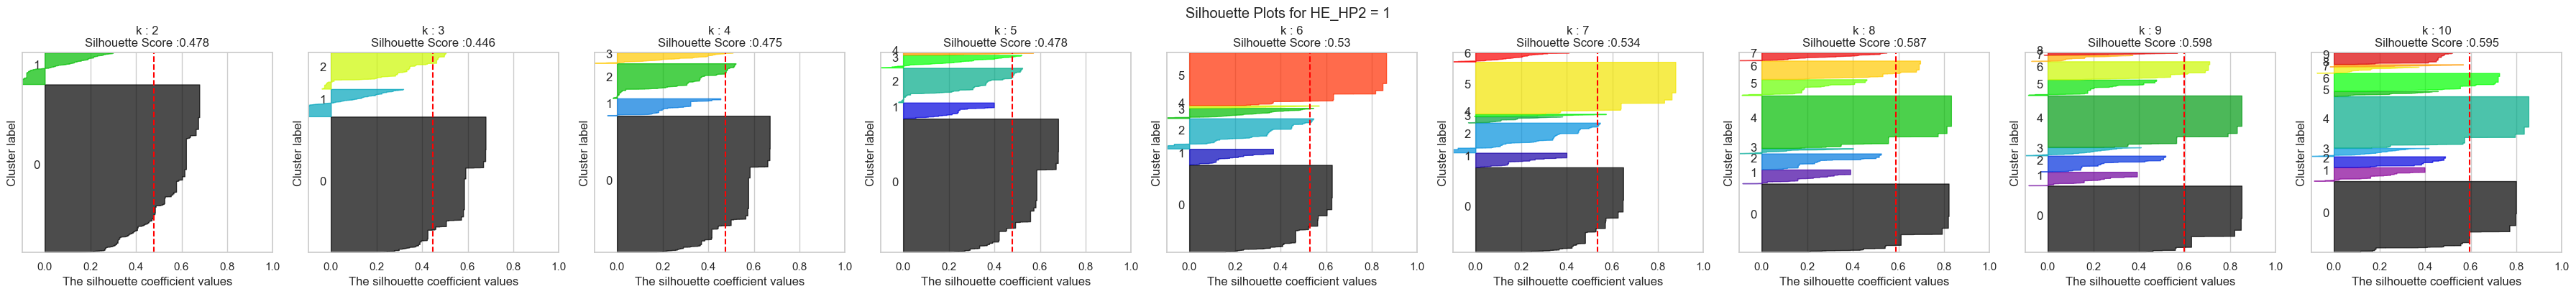


--- Processing HE_HP2 = 2 ---


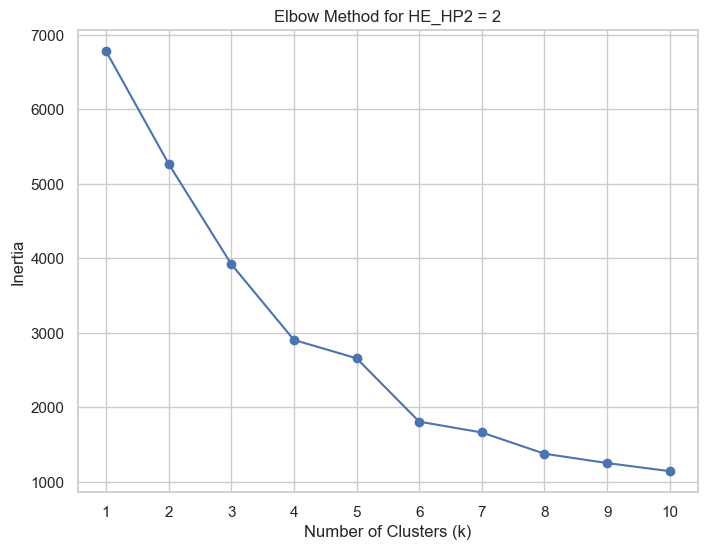

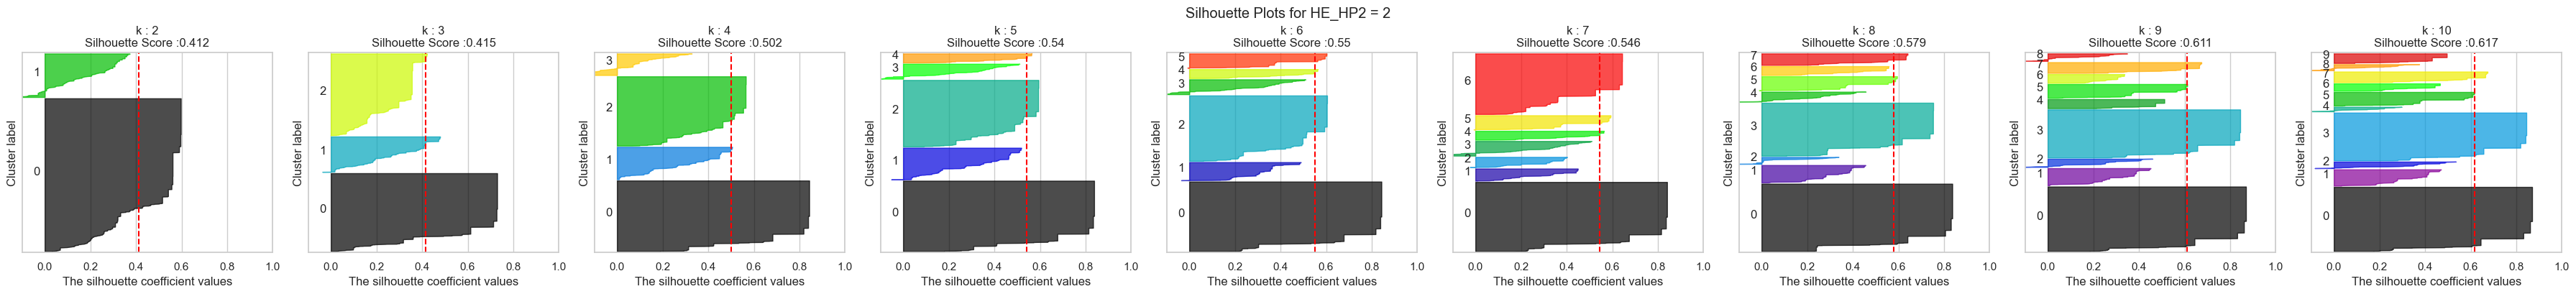


--- Processing HE_HP2 = 3 ---


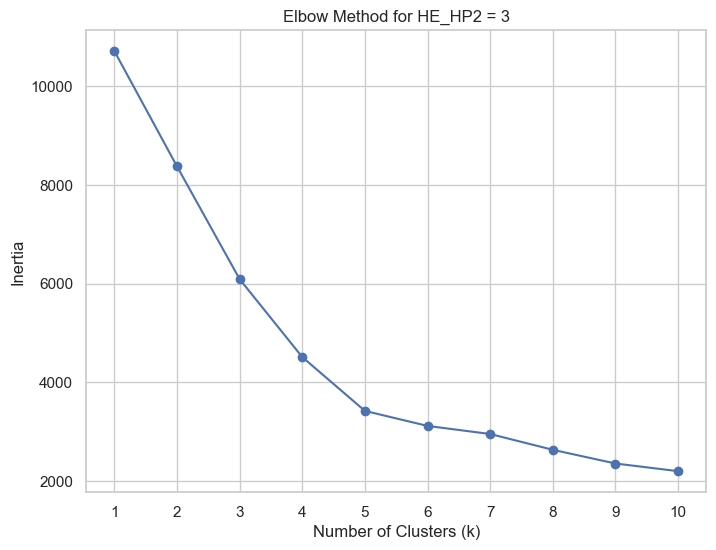

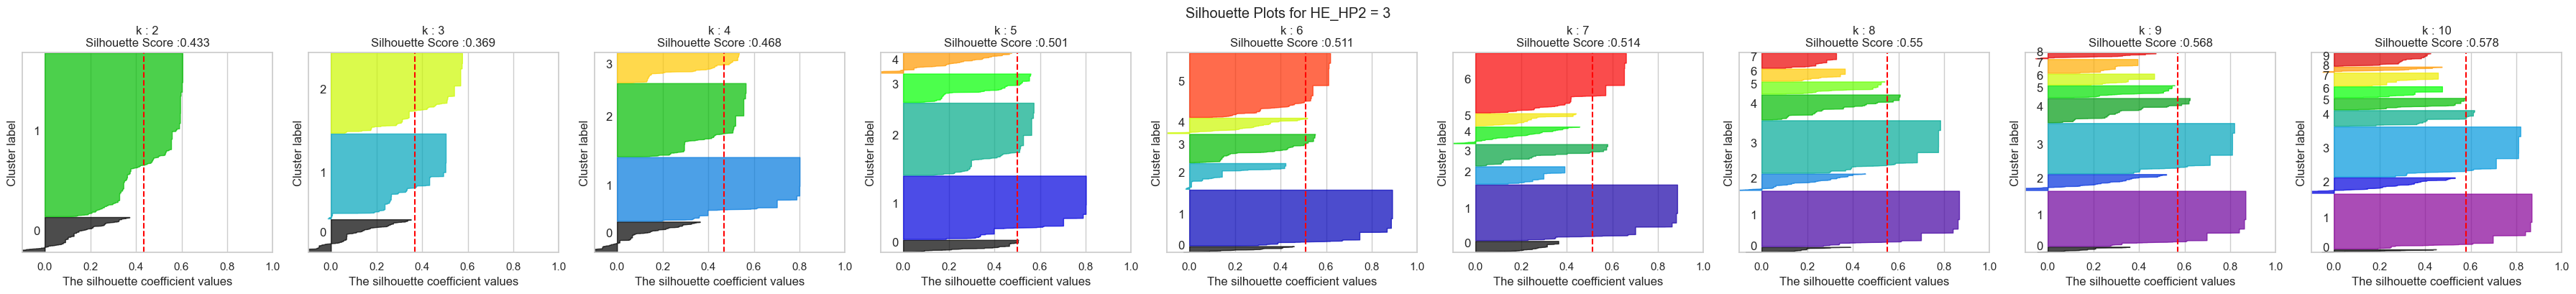


--- Processing HE_HP2 = 4 ---


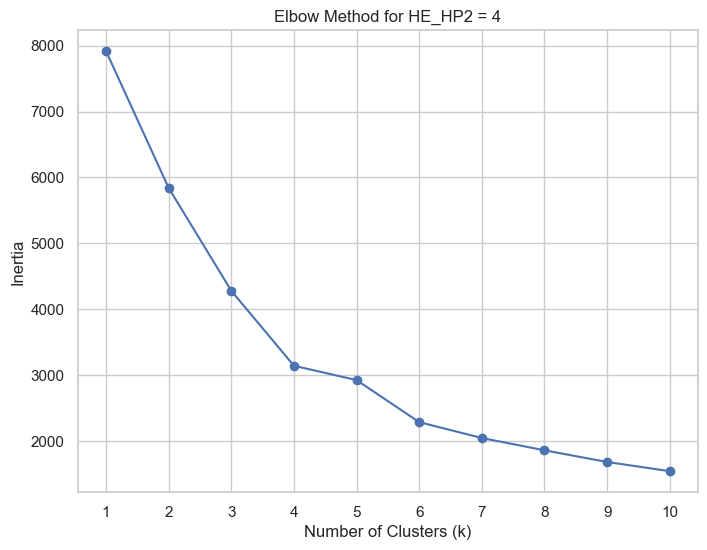

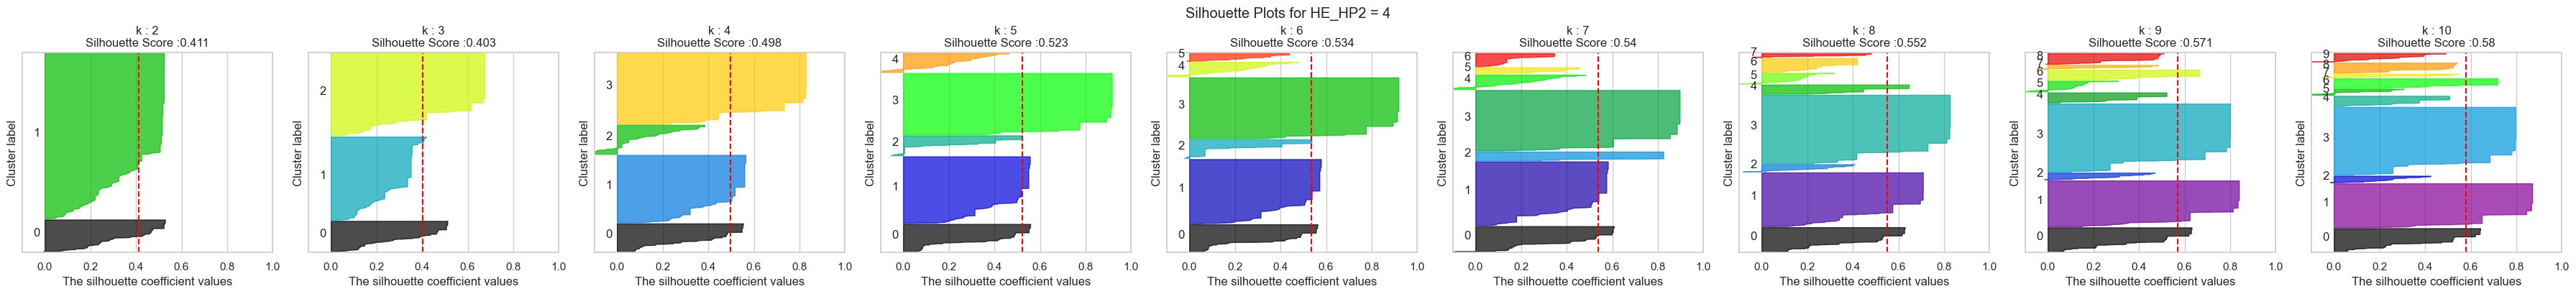


--- Processing complete ---


In [32]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm # For silhouette plot colors
import seaborn as sns

from sklearn.cluster import KMeans # KMeans 필요
from sklearn.preprocessing import StandardScaler # StandardScaler 필요
from sklearn.metrics import silhouette_samples, silhouette_score # silhouette_samples, silhouette_score 임포트 추가

# Assume df_clustering and knn_columns are defined and initialized before this snippet
# 예시 정의 (실제 코드에서는 이전에 정의된 변수를 사용해야 합니다)
# df_clustering = pd.read_csv("your_clustering_data.csv") # 실제 파일 경로
# knn_columns = ['HE_sbp1', 'HE_dbp1', 'HE_wc', 'HE_glu', 'HE_HbA1c', 'HE_chol', 'HE_HDL_st2', 'HE_LDL_drct', 'HE_crea', 'HE_ast', 'HE_alt', 'HE_wt', 'HE_ht', 'HE_BMI'] # 실제 knn_columns 목록


# 피처 표준화
scaler = StandardScaler()

# 클러스터 수 범위 설정 (엘보우 및 실루엣 시각화에 사용할 최대 k)
k_range_max = 10 # 최대 10개 클러스터까지 탐색

# 결과를 저장할 데이터프레임 준비
# 'Cluster' 칼럼이 이미 있다면 이 줄은 필요 없을 수 있습니다.
# df_clustering['Cluster'] = np.nan

# 군집 분석에 사용할 피처 목록 정의
# knn_columns와 추가 피처들을 결합합니다.
try:
    selected_cols =["BD1_11","tobacco","BE5_1","LS_VEG1"]
    # selected_cols에 포함된 모든 칼럼이 df_clustering에 있는지 확인하는 것이 안전합니다.
    missing_selected_cols = [col for col in selected_cols if col not in df_clustering.columns]
    if missing_selected_cols:
        print(f"Warning: Selected columns not found in df_clustering: {missing_selected_cols}")
        # 데이터에 없는 칼럼은 selected_cols에서 제외하고 진행할 수 있습니다.
        selected_cols = [col for col in selected_cols if col in df_clustering.columns]
        print(f"Using selected_cols found in data: {selected_cols}")

except NameError:
    print("Error: knn_columns is not defined. Please define knn_columns before running this code.")
    # knn_columns가 정의되지 않았을 경우의 예시 selected_cols (실제 사용하실 피처 목록으로 대체하세요)
    selected_cols = ["HE_sbp1", "HE_dbp1", "HE_wc", "HE_glu", "HE_HbA1c", "BD1_11", "tobacco", "BE5_1", "LS_VEG1"]
    print(f"Using example selected_cols: {selected_cols}")

# selected_cols가 비어있으면 분석 진행 불가
if not selected_cols:
    print("Error: selected_cols is empty. Cannot proceed with clustering.")
    # 스크립트 실행 중단 또는 적절한 오류 처리
    # exit()


# HE_HP 별로 반복
# df_clustering['HE_HP'] 칼럼이 존재하고, 그 값이 [1, 2, 3, 4] 중에 있다고 가정합니다.
# 실제 df_clustering['HE_HP']의 고유값 리스트를 사용하는 것이 더 안전합니다.
if 'HE_HP2' not in df_clustering.columns:
    print("Error: 'HE_HP2' column not found in df_clustering. Cannot perform clustering by HE_HP.")
    # 스크립트 실행 중단 또는 적절한 오류 처리
    # exit()

# HE_HP의 실제 고유값 가져오기 및 정렬
he_hp_values = sorted(df_clustering['HE_HP2'].dropna().unique().tolist())
# 만약 특정 HE_HP 값만 분석하고 싶다면 아래 리스트를 사용
# he_hp_values_to_process = [1, 2, 3, 4] # 분석할 HE_HP 값 목록

for hp_value in he_hp_values: # 실제 HE_HP 고유값 사용
    print(f"\n--- Processing HE_HP2 = {hp_value} ---")

    # HE_HP 값에 해당하는 데이터 추출
    # selected_cols에 해당하는 칼럼만 선택합니다.
    hp_df = df_clustering[df_clustering['HE_HP2'] == hp_value][selected_cols].copy()

    if not hp_df.empty and len(hp_df) > 1: # 데이터 포인트가 1개보다 많아야 클러스터링 의미 있음
        # 데이터 표준화
        # 각 그룹별로 별도의 scaler를 fit/transform 합니다.
        scaled_df = scaler.fit_transform(hp_df)

        # 클러스터 개수가 데이터 포인트 개수보다 많을 수는 없으므로 범위를 조정
        # 또한, 실루엣 계수 등 다른 검증 지표를 사용하려면 k>1 이어야 합니다.
        max_k_current_group = min(len(scaled_df), k_range_max) # 현재 그룹 데이터 개수와 최대 범위 중 작은 값

        if max_k_current_group < 2:
             print(f"  Not enough data points ({len(scaled_df)}) for HE_HP2 = {hp_value} to perform clustering for k > 1.")
             continue # 다음 HE_HP 값으로 넘어감


        # --- 엘보우 방법: 각 k에 대해 관성(Inertia) 계산 ---
        # 관성을 계산할 k 범위 (최소 1부터 시작)
        k_range_inertia = range(1, max_k_current_group + 1)
        inertias = []
        for k in k_range_inertia:
            # n_init='auto' 또는 숫자로 지정 (최신 sklearn 버전 권장)
            # k=1일때는 n_init=1로 설정 가능
            kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
            kmeans.fit(scaled_df)
            inertias.append(kmeans.inertia_)

        # 엘보우 플롯 시각화
        plt.figure(figsize=(8, 6))
        plt.plot(k_range_inertia, inertias, marker='o')
        plt.title(f'Elbow Method for HE_HP2 = {hp_value}')
        plt.xlabel('Number of Clusters (k)')
        plt.ylabel('Inertia')
        plt.xticks(k_range_inertia) # x축 틱을 k 범위로 설정
        plt.grid(True)
        plt.show()

        # --- 실루엣 계수 시각화 ---
        # 실루엣 계수를 계산할 k 범위 (최소 2부터 시작)
        k_range_silhouette = range(2, max_k_current_group + 1)

        if len(k_range_silhouette) > 0: # k_range_silhouette가 비어있지 않을 때만 시각화
            n_cols = len(k_range_silhouette)

            # plt.subplots()으로 리스트에 기재된 클러스터링 수만큼의 sub figures를 가지는 axs 생성
            # squeeze=False를 사용하여 n_cols=1일 때도 axs가 항상 2D 배열이 되도록 합니다.
            fig, axs = plt.subplots(figsize=(4 * n_cols, 4), nrows=1, ncols=n_cols, squeeze=False)
            axs = axs.reshape(-1) # 1D 배열로 평탄화

            # 리스트에 기재된 클러스터링 갯수들을 차례로 iteration 수행하면서 실루엣 개수 시각화
            for ind, n_cluster in enumerate(k_range_silhouette):
                ax = axs[ind] # 각 서브플롯 선택

                try:
                    # KMeans 클러스터링 수행하고, 실루엣 스코어와 개별 데이터의 실루엣 값 계산.
                    # n_init='auto' 또는 숫자로 지정 필요
                    clusterer = KMeans(n_clusters=n_cluster, max_iter=500, random_state=0, n_init='auto')
                    cluster_labels = clusterer.fit_predict(scaled_df)

                    # 실루엣 점수 계산
                    # 데이터 포인트가 1개보다 많고 클러스터 개수가 1개보다 많을 때만 계산 가능
                    if len(np.unique(cluster_labels)) > 1 and scaled_df.shape[0] > 1:
                         sil_avg = silhouette_score(scaled_df, cluster_labels)
                         sil_values = silhouette_samples(scaled_df, cluster_labels)
                    else:
                         sil_avg = 0 # 계산 불가 시 0 또는 NaN으로 처리
                         sil_values = np.zeros(scaled_df.shape[0]) # 모든 샘플 점수 0으로 처리
                         print(f" Silhouette score not computable for k={n_cluster} (less than 2 clusters or data points).")


                    y_lower = 10 # 첫 번째 클러스터 플롯의 시작 위치

                    # 플롯 제목 설정 (k값 및 평균 실루엣 점수 포함)
                    ax.set_title('k : ' + str(n_cluster)+'\n' \
                                 'Silhouette Score :' + str(round(sil_avg,3)) )
                    ax.set_xlabel("The silhouette coefficient values")
                    ax.set_ylabel("Cluster label")
                    ax.set_xlim([-0.1, 1]) # x축 범위 설정
                    # y축 범위 설정: 데이터 포인트 총 수 + (클러스터 개수 + 1) * 클러스터 간 간격
                    ax.set_ylim([0, len(scaled_df) + (n_cluster + 1) * 10])
                    ax.set_yticks([])  # yaxis labels / ticks 제거
                    ax.set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1]) # x축 틱 설정

                    # 각 클러스터별 실루엣 플롯 그리기
                    # 클러스터 라벨 순서대로 정렬하여 그립니다.
                    unique_labels = np.unique(cluster_labels)
                    unique_labels.sort() # 라벨을 오름차순으로 정렬하여 일관성 확보

                    for i in unique_labels: # 정렬된 고유 라벨 순회
                        # i번째 클러스터에 해당하는 실루엣 점수 가져오기
                        ith_cluster_sil_values = sil_values[cluster_labels == i]
                        ith_cluster_sil_values.sort() # 점수 정렬

                        size_cluster_i = ith_cluster_sil_values.shape[0] # 클러스터 i의 샘플 수
                        y_upper = y_lower + size_cluster_i # 현재 클러스터 플롯의 끝 위치

                        # 클러스터 색상 설정
                        color = cm.nipy_spectral(float(i) / len(unique_labels)) # 고유 라벨 개수로 색상 스케일링
                        # fill_betweenx를 사용하여 실루엣 점수 영역 채우기
                        ax.fill_betweenx(np.arange(y_lower, y_upper),
                                         0, ith_cluster_sil_values,
                                         facecolor=color, edgecolor=color, alpha=0.7)

                        # 클러스터 번호 텍스트 추가
                        ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

                        # 다음 클러스터 플롯을 위한 y_lower 위치 업데이트
                        y_lower = y_upper + 10 # 클러스터 간 간격 추가

                    # 평균 실루엣 점수 라인 추가
                    ax.axvline(x=sil_avg, color="red", linestyle="--")

                except Exception as e:
                    print(f"  Error visualizing silhouette for k={n_cluster}: {e}")
                    ax.set_title(f'k={n_cluster} (Error)')
                    ax.text(0.5, 0.5, 'Error', horizontalalignment='center', verticalalignment='center')
                    ax.set_xticks([])
                    ax.set_yticks([])

            # 전체 플롯 레이아웃 조정 및 제목 추가
            plt.tight_layout()
            plt.suptitle(f'Silhouette Plots for HE_HP2 = {hp_value}', y=1.02) # 전체 제목에 HE_HP 값 포함
            plt.show()

        else:
            print(f"  Not enough data points ({len(scaled_df)}) for HE_HP2 = {hp_value} to perform clustering for k > 1 for silhouette visualization.")



    else:
        print(f"No data or insufficient data points ({len(hp_df)}) for HE_HP2 = {hp_value} to perform clustering.")
        # 데이터가 없거나 부족하면 해당 HE_HP 값에 대한 클러스터 라벨을 NaN으로 유지
        # df_clustering.loc[hp_df.index, 'Cluster'] = np.nan # 이미 초기화 시 np.nan 이므로 필요 없을 수 있습니다.


print("\n--- Processing complete ---")

# 루프가 완료된 후, df_clustering 데이터프레임에는 각 HE_HP 그룹에 대해
# 결정된 optimal_k로 군집화된 'Cluster' 라벨이 추가되어 있습니다.
# 이제 이 df_clustering를 사용하여 군집별 특징 분석, 시각화 등을 수행할 수 있습니다.


k-평균, 계층적 군집화, minibatch 방법 비교 


--- Processing HE_HP = 1 with k = 5 ---
Comparing algorithms for k = 5:
  - KMeans: Silhouette Score = 0.4356
  - Agglomerative: Silhouette Score = 0.3888
  - MiniBatchKMeans: Silhouette Score = 0.4355

Best algorithm for HE_HP = 1 (k=5): KMeans (Silhouette Score: 0.4356)
Cluster Characteristics (Mean values for HE_HP = 1, k=5):
             1년 간 음주 빈도   하루평균 흡연량  1주일 간 운동 횟수  1년 동안 평균 채소류 섭취 빈도
New_Cluster                                                        
0             25.313167   0.401246     0.185943         1095.000000
1             38.881239   1.247849     0.421687          340.211704
2             33.785124   0.507231     0.238636          730.000000
3             92.463612  18.991914     0.560647          758.730458
4             35.631579   0.826316     4.100000          831.359211
------------------------------------------------------------


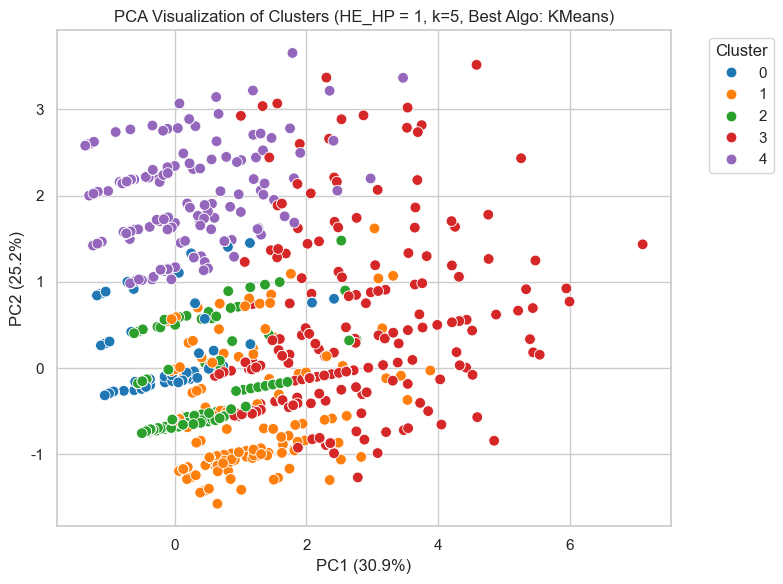


--- Processing HE_HP = 2 with k = 5 ---
Comparing algorithms for k = 5:
  - KMeans: Silhouette Score = 0.5114
  - Agglomerative: Silhouette Score = 0.4846
  - MiniBatchKMeans: Silhouette Score = 0.5046

Best algorithm for HE_HP = 2 (k=5): KMeans (Silhouette Score: 0.5114)
Cluster Characteristics (Mean values for HE_HP = 2, k=5):
             1년 간 음주 빈도   하루평균 흡연량  1주일 간 운동 횟수  1년 동안 평균 채소류 섭취 빈도
New_Cluster                                                        
0             15.765957   0.351064     0.187943          644.741135
1            201.724138   2.091954     0.505747          849.264368
2             32.167832   1.398601     4.223776          907.209790
3             61.858824  17.658824     0.670588          762.941176
4              8.715789   0.133333     0.168421         1095.000000
------------------------------------------------------------


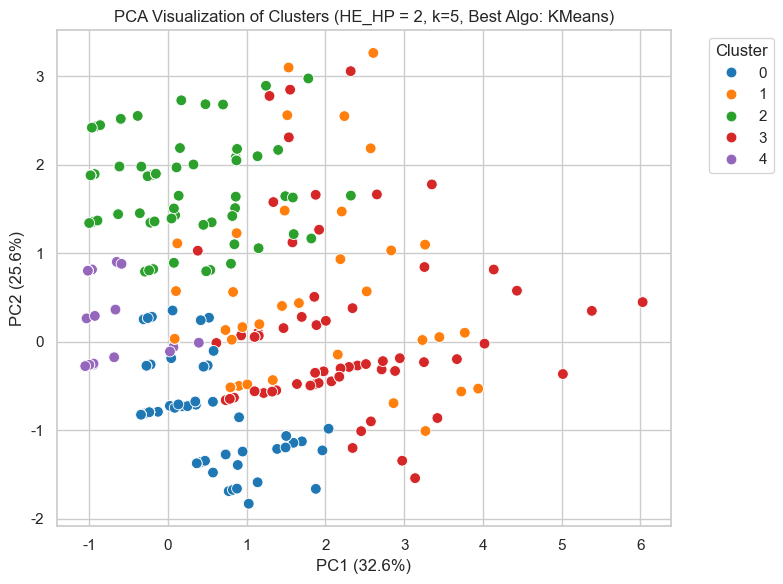


--- Processing HE_HP = 3 with k = 5 ---
Comparing algorithms for k = 5:
  - KMeans: Silhouette Score = 0.4493
  - Agglomerative: Silhouette Score = 0.3979
  - MiniBatchKMeans: Silhouette Score = 0.4516

Best algorithm for HE_HP = 3 (k=5): MiniBatchKMeans (Silhouette Score: 0.4516)
Cluster Characteristics (Mean values for HE_HP = 3, k=5):
             1년 간 음주 빈도   하루평균 흡연량  1주일 간 운동 횟수  1년 동안 평균 채소류 섭취 빈도
New_Cluster                                                        
0             37.431856   0.853859     0.231527          657.085386
1             30.242424   0.475524     0.172494         1095.000000
2            286.000000   6.672414     0.715517          806.862069
3             39.338983   1.279661     4.224576          893.271186
4             83.592593  19.240741     0.339506          783.746914
------------------------------------------------------------


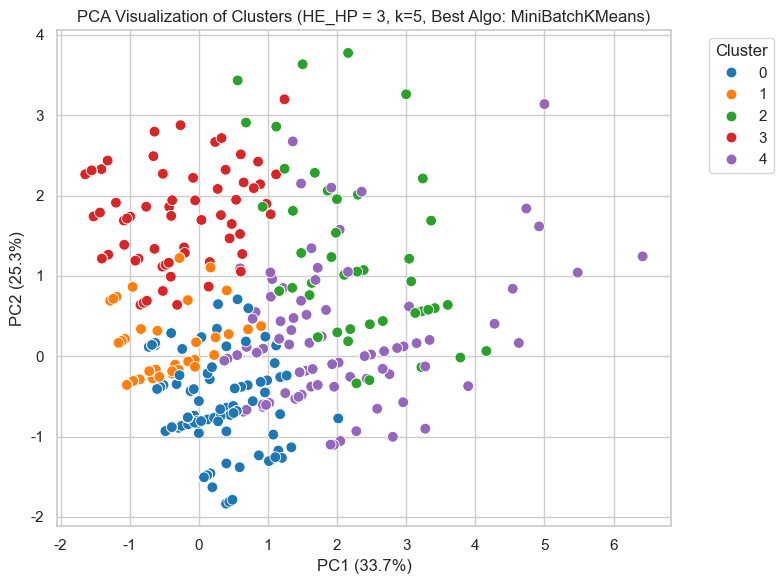


--- Processing HE_HP = 4 with k = 5 ---
Comparing algorithms for k = 5:
  - KMeans: Silhouette Score = 0.5618
  - Agglomerative: Silhouette Score = 0.5344
  - MiniBatchKMeans: Silhouette Score = 0.5685

Best algorithm for HE_HP = 4 (k=5): MiniBatchKMeans (Silhouette Score: 0.5685)
Cluster Characteristics (Mean values for HE_HP = 4, k=5):
             1년 간 음주 빈도   하루평균 흡연량  1주일 간 운동 횟수  1년 동안 평균 채소류 섭취 빈도
New_Cluster                                                        
0             33.828125   0.748047     4.410156          950.996094
1             24.836302   0.631891     0.139101          671.674300
2             19.889896   0.320596     0.079016         1095.000000
3            129.793939  19.475758     0.530303          839.966667
4            286.000000   2.117647     1.008403          914.252101
------------------------------------------------------------


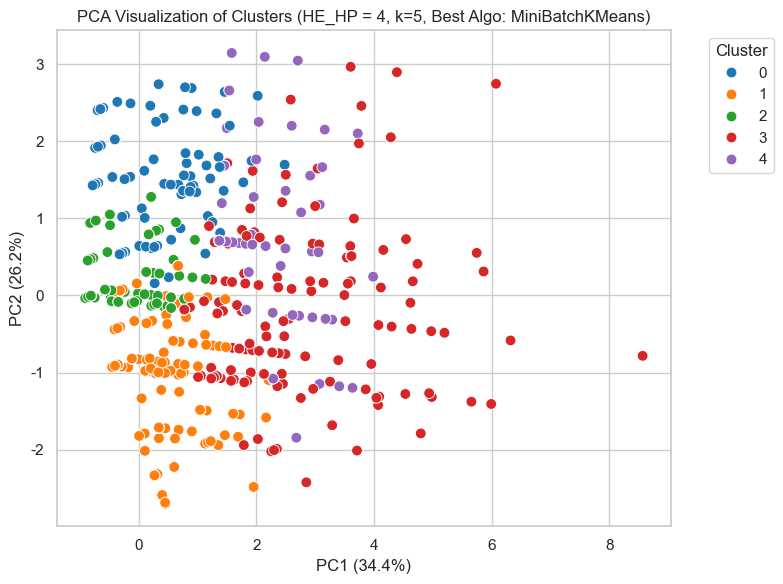


--- Processing complete ---


In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm # For silhouette plot colors
import seaborn as sns

from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN, MiniBatchKMeans # AgglomerativeClustering, DBSCAN, MiniBatchKMeans 임포트 추가
from sklearn.preprocessing import StandardScaler, OneHotEncoder, RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.impute import KNNImputer
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_samples, silhouette_score

# RandomForestClassifier는 이 특정 스니펫에서 직접 사용되지 않으므로 주석 처리하거나 필요에 따라 유지
# from sklearn.ensemble import RandomForestClassifier

# 통계 분석을 위한 라이브러리 임포트 (이 스니펫에서 직접 사용되지는 않음)
# from scipy import stats
# import statsmodels.api as sm
# from statsmodels.stats.contingency_tables import Table

# 시각화 설정
sns.set(style="whitegrid")

# 전처리 함수 (이 스니펫에서 정의되지 않았지만, 외부에서 정의되어 사용된다고 가정)
# def preprocess_data(df, original_numeric_cols, original_categorical_cols): ...

# select_features 함수 (이 스니펫에서 정의되지 않았지만, 외부에서 정의되어 사용된다고 가정)
# def select_features(df, columns, corr_threshold=0.8): ...

# compute_feature_importance 함수 (이 스니펫에서 정의되지 않았지만, 외부에서 정의되어 사용된다고 가정)
# def compute_feature_importance(df_processed, selected_cols, cluster_labels): ...

# visualize_silhouette 함수 (이 스니펫에서 정의되지 않았지만, 외부에서 정의되어 사용된다고 가정)
# def visualize_silhouette(cluster_lists, X_features): ...

# run_clustering_iteration 함수 (이 스니펫에서 정의되지 않았지만, 외부에서 정의되어 사용된다고 가정)
# def run_clustering_iteration(df_original, features_to_use, original_numeric_cols, original_categorical_cols, n_clusters, algorithm): ...


# 매핑 딕셔너리 정의 (피처 이름 -> 한글 설명)
# 이 딕셔너리는 selected_cols에 있는 피처 이름에 대한 설명을 포함해야 합니다.
feature_korean_names = {
    'HE_sbp1': '수축기 혈압 (최고 혈압)',
    'HE_dbp1': '이완기 혈압 (최저 혈압)',
    'HE_wc': '허리둘레',
    'HE_glu': '혈당',
    'HE_chol': '총 콜레스테롤',
    'HE_HDL_st2': 'HDL 콜레스테롤 (좋은 콜레스테롤)',
    'HE_LDL_drct': 'LDL 콜레스테롤 (나쁜 콜레스테롤)',
    'HE_crea': '크레아티닌 (신장 기능 지표)',
    'HE_ast': 'AST (간 기능 검사, GOT)',
    'HE_alt': 'ALT (간 기능 검사, GPT)',
    'HE_wt': '체중',
    'HE_ht': '키',
    'HE_BMI': '체질량 지수 (BMI)',
    'BD1_11': '1년 간 음주 빈도',
    'tobacco': '하루평균 흡연량', # 이 피처가 selected_cols에 있는지 확인 필요
    'BE5_1' : '1주일 간 운동 횟수',
    'LS_VEG1': '1년 동안 평균 채소류 섭취 빈도',
    # selected_cols에 포함된 다른 피처들도 여기에 추가해야 합니다.
    'age': '나이', 'sex': '성별', 'HE_HbA1c': '당화혈색소', # 예시 추가
    # ... selected_cols에 있는 모든 피처에 대한 매핑 추가 ...
}

# 시각화 설정
sns.set(style="whitegrid")

# Assume df_clustering, selected_cols, scaler are defined and initialized before this snippet
# 예시 정의 (실제 코드에서는 이전에 정의된 변수를 사용해야 합니다)
# df_clustering = pd.read_csv("your_clustering_data.csv") # 실제 파일 경로
# selected_cols = ['HE_sbp1', 'HE_dbp1', 'HE_wc', 'HE_glu', 'HE_chol', 'HE_HDL_st2', 'HE_LDL_drct', 'HE_crea', 'HE_ast', 'HE_alt', 'HE_wt', 'HE_ht', 'HE_BMI', 'BD1_11', 'tobacco', 'BE5_1', 'LS_VEG1', 'age', 'sex', 'HE_HbA1c'] # 실제 selected_cols 목록
# scaler = StandardScaler() # 스케일러 객체 (fit 되어 있어야 함)
# df_clustering['HE_HP'] 칼럼이 존재하고, 그 값이 [1, 2, 3, 4] 중에 있다고 가정합니다.


# 비교할 군집화 알고리즘 정의 (n_clusters를 사용하는 알고리즘)
# MiniBatchKMeans 추가
algorithms_to_compare = {
    'KMeans': KMeans,
    'Agglomerative': AgglomerativeClustering,
    'MiniBatchKMeans': MiniBatchKMeans, # MiniBatchKMeans 추가
    # DBSCAN은 n_clusters 대신 다른 매개변수를 사용하므로 이 비교 루프에서는 제외합니다.
}


# HE_HP 별로 반복
# optimal_k 리스트는 각 HE_HP 값에 대해 미리 결정되어 있어야 합니다.
# 예: optimal_k_list = [3, 5, 5, 5]
# HE_HP_values = [1, 2, 3, 4] # 실제 HE_HP 고유값
# for hp_value, optimal_k in zip(HE_HP_values, optimal_k_list):

for hp_value, optimal_k in zip([1, 2, 3, 4], [5, 5, 5, 5]): # 제공해주신 예시 값 사용
    print(f"\n--- Processing HE_HP = {hp_value} with k = {optimal_k} ---")

    # 해당 그룹 데이터 추출
    # selected_cols는 이전에 정의되어 있어야 함
    # df_clustering는 이전에 로드/처리되어 있어야 함
    hp_df = df_clustering[df_clustering['HE_HP'] == hp_value][selected_cols].copy()

    if not hp_df.empty:
        # 표준화 (각 그룹별로 스케일링)
        # scaler는 이전에 fit 되어 있어야 하지만, 여기서는 각 그룹별로 fit_transform을 다시 수행합니다.
        # 만약 전체 데이터로 fit 했다면 여기서 transform만 사용해야 합니다.
        # 제공해주신 코드 형태대로 매 그룹별로 fit_transform 하는 경우를 따릅니다.
        scaled_df = scaler.fit_transform(hp_df)

        # --- 다양한 군집화 알고리즘 비교 ---
        best_score = -1 # 가장 높은 실루엣 점수 추적
        best_labels = None # 가장 좋은 알고리즘의 클러스터 라벨 추적
        best_algo_name = None # 가장 좋은 알고리즘 이름 추적

        print(f"Comparing algorithms for k = {optimal_k}:")

        for algo_name, algo_class in algorithms_to_compare.items():
            try:
                # 클러스터 개수가 1개보다 많고, 데이터 포인트가 1개보다 많을 때만 유효한 비교
                if optimal_k > 1 and scaled_df.shape[0] > 1:
                    # 알고리즘 인스턴스 생성
                    if algo_name in ['KMeans', 'MiniBatchKMeans']: # KMeans 또는 MiniBatchKMeans
                        # n_init='auto' 또는 숫자로 지정 필요
                        model = algo_class(n_clusters=optimal_k, random_state=42, n_init='auto')
                    else: # Agglomerative Clustering
                        # Agglomerative Clustering은 n_init 매개변수 없음
                        model = algo_class(n_clusters=optimal_k)

                    # 클러스터링 수행
                    current_labels = model.fit_predict(scaled_df)

                    # 실루엣 점수 계산
                    # DBSCAN과 달리 이 알고리즘들은 모든 데이터에 라벨을 할당하므로 노이즈 제외 로직은 필요 없습니다.
                    current_score = silhouette_score(scaled_df, current_labels)
                    print(f"  - {algo_name}: Silhouette Score = {current_score:.4f}")

                    # 가장 높은 점수 업데이트
                    if current_score > best_score:
                        best_score = current_score
                        best_labels = current_labels # 현재 알고리즘의 라벨 저장
                        best_algo_name = algo_name # 현재 알고리즘 이름 저장

                else:
                    # 클러스터 개수가 1개 이하이거나 데이터 포인트가 부족하면 실루엣 점수 계산 불가
                    print(f"  - {algo_name}: Silhouette Score not computable (k<2 or insufficient data).")
                    # best_score는 여전히 -1 (초기값) 유지

            except Exception as e:
                print(f"  - {algo_name} failed: {e}")
                # 오류 발생 시 해당 알고리즘은 무시하고 계속 진행

        # --- 가장 높은 실루엣 점수를 가진 알고리즘의 결과 사용 ---
        if best_labels is not None:
            print(f"\nBest algorithm for HE_HP = {hp_value} (k={optimal_k}): {best_algo_name} (Silhouette Score: {best_score:.4f})")
            final_cluster_labels = best_labels # 가장 좋은 라벨 사용
        else:
            print(f"\nCould not find a suitable clustering result for HE_HP = {hp_value} (k={optimal_k}). Skipping analysis for this group.")
            continue # 이 그룹에 대한 분석 건너뛰기

        # 군집별 특징 계산 및 출력
        # 1. 원본 데이터프레임에 최종 클러스터 라벨 추가
        # 인덱스가 맞아야 함
        hp_df_with_labels = hp_df.copy() # 원본 hp_df 변경 방지를 위해 복사
        hp_df_with_labels['New_Cluster'] = final_cluster_labels # 가장 좋은 라벨 사용

        # 2. 'New_Cluster' 기준으로 그룹화하고 각 피처의 평균 계산
        cluster_characteristics = hp_df_with_labels.groupby('New_Cluster')[selected_cols].mean()

        # 3. 결과 출력을 위해 컬럼 이름을 한글로 변경
        # selected_cols에 포함된 피처 이름만 매핑 (딕셔너리에 없는 컬럼은 원래 이름 유지)
        cols_to_rename = {col: feature_korean_names.get(col, col) for col in cluster_characteristics.columns}
        cluster_characteristics = cluster_characteristics.rename(columns=cols_to_rename)

        # 4. 결과 출력
        print(f"Cluster Characteristics (Mean values for HE_HP = {hp_value}, k={optimal_k}):")
        print(cluster_characteristics)
        print("-" * 60) # 구분선

        # 클러스터 라벨 변수 이름을 final_cluster_labels로 변경 (혼동 방지)
        cluster_labels_for_pca = final_cluster_labels

        # PCA 2차원 축소
        # 스케일링된 데이터를 PCA에 사용
        pca = PCA(n_components=2)
        pca_result = pca.fit_transform(scaled_df) # 스케일링된 데이터를 PCA에 사용

        # 결과를 데이터프레임으로 변환
        pca_df = pd.DataFrame(data=pca_result, columns=['PC1', 'PC2'])
        # 최종 클러스터 라벨 사용
        pca_df['Cluster'] = cluster_labels_for_pca.astype(int)

        # 시각화 (나머지 코드 동일) - PCA 플롯의 축 이름은 PC1, PC2로 유지
        plt.figure(figsize=(8, 6))
        sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='Cluster', palette='tab10', s=60)
        # 제목에 HE_HP 값, k값, 사용된 알고리즘 이름 추가
        plt.title(f'PCA Visualization of Clusters (HE_HP = {hp_value}, k={optimal_k}, Best Algo: {best_algo_name})')
        plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)')
        plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)')
        plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.tight_layout()
        plt.show()

    else:
        print(f"No data for HE_HP = {hp_value}")
        print("-" * 60) # 구분선

print("\n--- Processing complete ---")


음주는 1주 단위로. 채소는 하루 단위로 변경 


--- Processing HE_HP2 = 1 with k = 5 ---
Comparing algorithms for k = 5:
  - KMeans: Silhouette Score = 0.4987
  - Agglomerative: Silhouette Score = 0.4867
  - MiniBatchKMeans: Silhouette Score = 0.5233

Best algorithm for HE_HP2 = 1 (k=5): MiniBatchKMeans (Silhouette Score: 0.5233)
Cluster Characteristics (Mean values for HE_HP2 = 1, k=5) - Modified:
             1주일 간 음주 빈도  하루 평균 흡연량  1주일 간 운동 횟수  하루 평균 채소 섭취 빈도
New_Cluster                                                     
0               0.455225   0.655660     3.760377        2.224782
1               0.145515   0.241341     0.145135        3.000000
2               1.419121  20.365714     0.594286        2.064047
3               0.205694   0.414883     0.087916        1.763966
4               3.244792   2.083333     0.510417        2.088171
------------------------------------------------------------


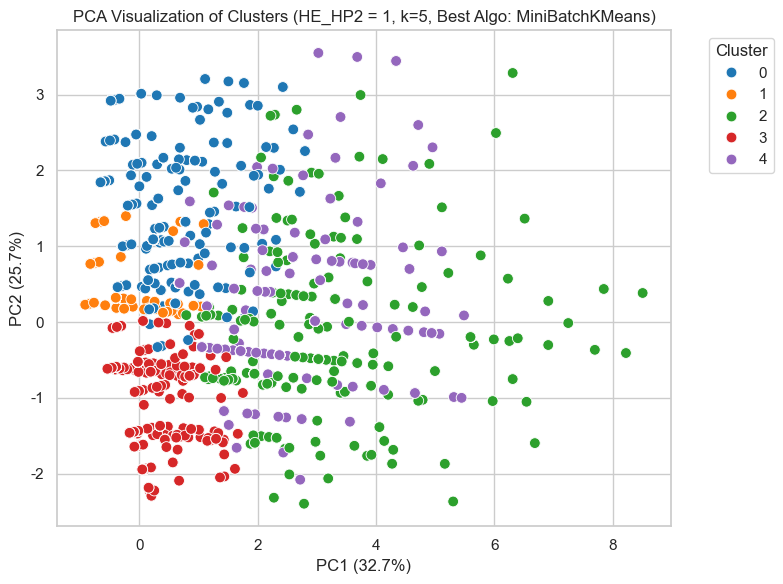


--- Processing HE_HP2 = 2 with k = 5 ---
Comparing algorithms for k = 5:
  - KMeans: Silhouette Score = 0.5101
  - Agglomerative: Silhouette Score = 0.5125
  - MiniBatchKMeans: Silhouette Score = 0.5381

Best algorithm for HE_HP2 = 2 (k=5): MiniBatchKMeans (Silhouette Score: 0.5381)
Cluster Characteristics (Mean values for HE_HP2 = 2, k=5) - Modified:
             1주일 간 음주 빈도  하루 평균 흡연량  1주일 간 운동 횟수  하루 평균 채소 섭취 빈도
New_Cluster                                                     
0               0.406630   0.398990     0.210438        1.808173
1               0.292432   0.270968     0.108065        3.000000
2               0.593664   0.946043     4.266187        2.333734
3               5.500000   4.475000     0.787500        2.387500
4               0.923390  18.747967     0.544715        2.182337
------------------------------------------------------------


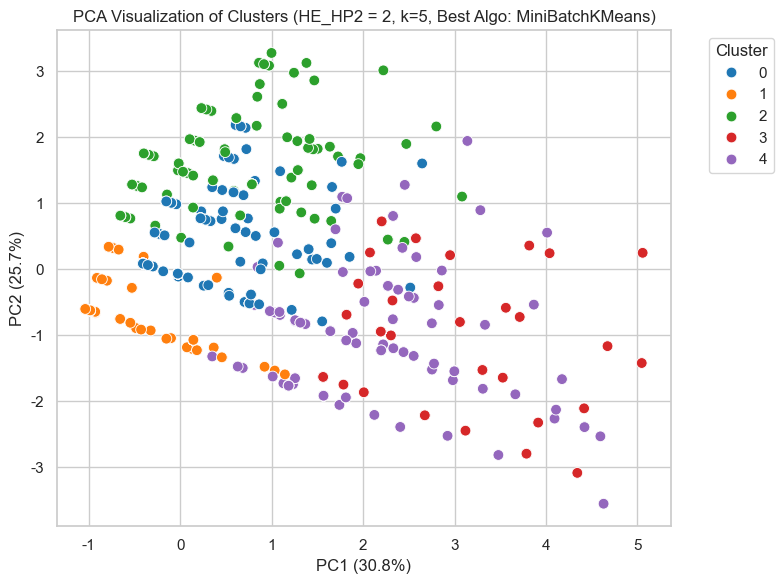


--- Processing HE_HP2 = 3 with k = 5 ---
Comparing algorithms for k = 5:
  - KMeans: Silhouette Score = 0.5008
  - Agglomerative: Silhouette Score = 0.4608
  - MiniBatchKMeans: Silhouette Score = 0.4830

Best algorithm for HE_HP2 = 3 (k=5): KMeans (Silhouette Score: 0.5008)
Cluster Characteristics (Mean values for HE_HP2 = 3, k=5) - Modified:
             1주일 간 음주 빈도  하루 평균 흡연량  1주일 간 운동 횟수  하루 평균 채소 섭취 빈도
New_Cluster                                                     
0               0.716433   0.827763     4.254499        2.517252
1               0.559872   0.683049     0.211635        1.830104
2               2.072572  18.536496     0.437956        2.161454
3               0.452642   0.344074     0.139241        3.000000
4               5.500000   3.120805     0.791946        2.361442
------------------------------------------------------------


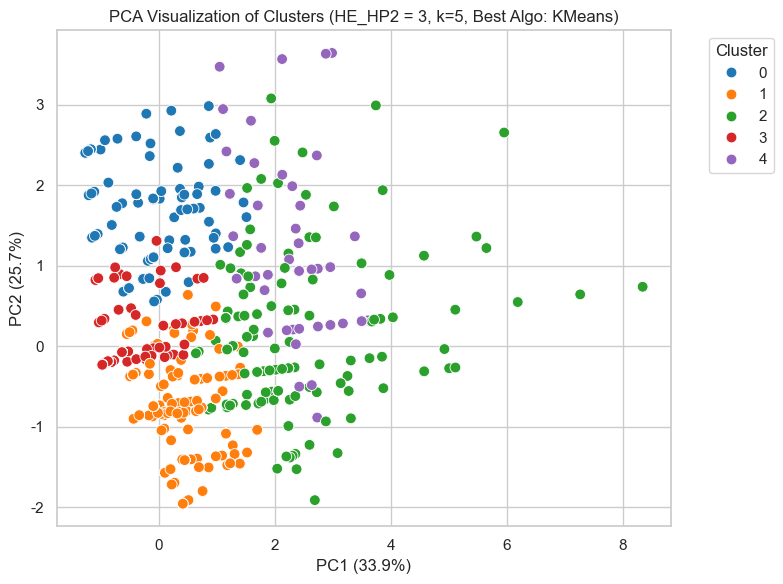


--- Processing HE_HP2 = 4 with k = 5 ---
Comparing algorithms for k = 5:
  - KMeans: Silhouette Score = 0.4825
  - Agglomerative: Silhouette Score = 0.4919
  - MiniBatchKMeans: Silhouette Score = 0.5306

Best algorithm for HE_HP2 = 4 (k=5): MiniBatchKMeans (Silhouette Score: 0.5306)
Cluster Characteristics (Mean values for HE_HP2 = 4, k=5) - Modified:
             1주일 간 음주 빈도  하루 평균 흡연량  1주일 간 운동 횟수  하루 평균 채소 섭취 빈도
New_Cluster                                                     
0               0.575455   0.950382     4.416031        2.567876
1               0.457307   0.371866     0.089136        3.000000
2               0.616066   0.645495     0.172821        1.824718
3               2.822274  20.527473     0.576923        2.261749
4               5.500000   2.307143     1.057143        2.401018
------------------------------------------------------------


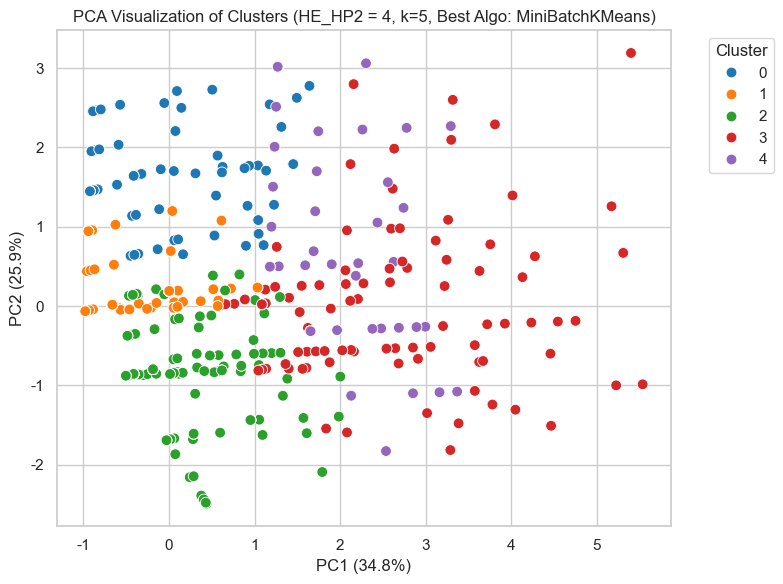


--- Processing complete ---


In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm # For silhouette plot colors
import seaborn as sns

from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN, MiniBatchKMeans # AgglomerativeClustering, DBSCAN, MiniBatchKMeans 임포트 추가
from sklearn.preprocessing import StandardScaler, OneHotEncoder, RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.impute import KNNImputer
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_samples, silhouette_score

# RandomForestClassifier는 이 특정 스니펫에서 직접 사용되지 않으므로 주석 처리하거나 필요에 따라 유지
# from sklearn.ensemble import RandomForestClassifier

# 통계 분석을 위한 라이브러리 임포트 (이 스니펫에서 직접 사용되지는 않음)
# from scipy import stats
# import statsmodels.api as sm
# from statsmodels.stats.contingency_tables import Table

# 시각화 설정
sns.set(style="whitegrid")

# 전처리 함수 (이 스니펫에서 정의되지 않았지만, 외부에서 정의되어 사용된다고 가정)
# def preprocess_data(df, original_numeric_cols, original_categorical_cols): ...

# select_features 함수 (이 스니펫에서 정의되지 않았지만, 외부에서 정의되어 사용된다고 가정)
# def select_features(df, columns, corr_threshold=0.8): ...

# compute_feature_importance 함수 (이 스니펫에서 정의되지 않았지만, 외부에서 정의되어 사용된다고 가정)
# def compute_feature_importance(df_processed, selected_cols, cluster_labels): ...

# visualize_silhouette 함수 (이 스니펫에서 정의되지 않았지만, 외부에서 정의되어 사용된다고 가정)
# def visualize_silhouette(cluster_lists, X_features): ...

# run_clustering_iteration 함수 (이 스니펫에서 정의되지 않았지만, 외부에서 정의되어 사용된다고 가정)
# def run_clustering_iteration(df_original, features_to_use, original_numeric_cols, original_categorical_cols, n_clusters, algorithm): ...


# 매핑 딕셔너리 정의 (피처 이름 -> 한글 설명)
# 이 딕셔너리는 selected_cols에 있는 피처 이름에 대한 설명을 포함해야 합니다.
# 이 딕셔너리는 PCA 플롯 등의 원래 피처 라벨링에 사용됩니다.
feature_korean_names = {
    'HE_sbp1': '수축기 혈압 (최고 혈압)',
    'HE_dbp1': '이완기 혈압 (최저 혈압)',
    'HE_wc': '허리둘레',
    'HE_glu': '혈당',
    'HE_chol': '총 콜레스테롤',
    'HE_HDL_st2': 'HDL 콜레스테롤 (좋은 콜레스테롤)',
    'HE_LDL_drct': 'LDL 콜레스테롤 (나쁜 콜레스테롤)',
    'HE_crea': '크레아티닌 (신장 기능 지표)',
    'HE_ast': 'AST (간 기능 검사, GOT)',
    'HE_alt': 'ALT (간 기능 검사, GPT)',
    'HE_wt': '체중',
    'HE_ht': '키',
    'HE_BMI': '체질량 지수 (BMI)',
    'BD1_11': '1주일 간 음주 빈도', # 원본 피처 이름 유지
    'tobacco': '하루 평균 흡연량',
    'BE5_1' : '1주일 간 운동 횟수',
    'LS_VEG1': '하루 평균 채소류 섭취 빈도', # 원본 피처 이름 유지
    # selected_cols에 포함된 다른 피처들도 여기에 추가해야 합니다.
    'age': '나이', 'sex': '성별', 'HE_HbA1c': '당화혈색소', # 예시 추가
    # ... selected_cols에 있는 모든 피처에 대한 매핑 추가 ...
}

# 시각화 설정
sns.set(style="whitegrid")

# Assume df_clustering, selected_cols, scaler are defined and initialized before this snippet
# 예시 정의 (실제 코드에서는 이전에 정의된 변수를 사용해야 합니다)
# df_clustering = pd.read_csv("your_clustering_data.csv") # 실제 파일 경로
# selected_cols는 이전에 정의되어 있어야 함 (예: ['BD1_11', 'tobacco', 'BE5_1', 'LS_VEG1'])
# scaler = StandardScaler() # 스케일러 객체 (fit 되어 있어야 함)
# df_clustering['HE_HP'] 칼럼이 존재하고, 그 값이 [1, 2, 3, 4] 중에 있다고 가정합니다.


# 비교할 군집화 알고리즘 정의 (n_clusters를 사용하는 알고리즘)
# MiniBatchKMeans 추가
algorithms_to_compare = {
    'KMeans': KMeans,
    'Agglomerative': AgglomerativeClustering,
    'MiniBatchKMeans': MiniBatchKMeans, # MiniBatchKMeans 추가
    # DBSCAN은 n_clusters 대신 다른 매개변수를 사용하므로 이 비교 루프에서는 제외합니다.
}

# 군집 분석에 사용할 피처 목록 정의 (원본 데이터 기준)
selected_cols = ["BD1_11","tobacco","BE5_1","LS_VEG1"]

# 피처 표준화 (전체 데이터에 대해 한 번 fit 할 수도 있고, 각 그룹별로 fit 할 수도 있습니다.
# 제공해주신 코드 형태대로 각 그룹별로 fit_transform 하는 경우를 따릅니다.)
scaler = StandardScaler()



for hp_value, optimal_k in zip([1, 2, 3, 4], [5, 5, 5, 5]): # 제공해주신 예시 값 사용
    print(f"\n--- Processing HE_HP2 = {hp_value} with k = {optimal_k} ---")

    # 해당 그룹 데이터 추출
    # selected_cols는 이전에 정의되어 있어야 함
    # df_clustering는 이전에 로드/처리되어 있어야 함
    hp_df = df_clustering[df_clustering['HE_HP2'] == hp_value][selected_cols].copy()

    if not hp_df.empty and len(hp_df) > 1: # 데이터 포인트가 1개보다 많아야 클러스터링 의미 있음
        # 표준화 (각 그룹별로 스케일링)
        # scaler는 이전에 fit 되어 있어야 하지만, 여기서는 각 그룹별로 fit_transform을 다시 수행합니다.
        # 만약 전체 데이터로 fit 했다면 여기서 transform만 사용해야 합니다.
        # 제공해주신 코드 형태대로 매 그룹별로 fit_transform 하는 경우를 따릅니다.
        scaled_df = scaler.fit_transform(hp_df)

        # --- 다양한 군집화 알고리즘 비교 ---
        best_score = -1 # 가장 높은 실루엣 점수 추적
        best_labels = None # 가장 좋은 알고리즘의 클러스터 라벨 추적
        best_algo_name = None # 가장 좋은 알고리즘 이름 추적

        print(f"Comparing algorithms for k = {optimal_k}:")

        for algo_name, algo_class in algorithms_to_compare.items():
            try:
                # 클러스터 개수가 1개보다 많고, 데이터 포인트가 1개보다 많을 때만 유효한 비교
                if optimal_k > 1 and scaled_df.shape[0] > 1:
                    # 알고리즘 인스턴스 생성
                    if algo_name in ['KMeans', 'MiniBatchKMeans']: # KMeans 또는 MiniBatchKMeans
                        # n_init='auto' 또는 숫자로 지정 필요
                        model = algo_class(n_clusters=optimal_k, random_state=42, n_init='auto')
                    else: # Agglomerative Clustering
                        # Agglomerative Clustering은 n_init 매개변수 없음
                        model = algo_class(n_clusters=optimal_k)

                    # 클러스터링 수행
                    current_labels = model.fit_predict(scaled_df)

                    # 실루엣 점수 계산
                    # DBSCAN과 달리 이 알고리즘들은 모든 데이터에 라벨을 할당하므로 노이즈 제외 로직은 필요 없습니다.
                    current_score = silhouette_score(scaled_df, current_labels)
                    print(f"  - {algo_name}: Silhouette Score = {current_score:.4f}")

                    # 가장 높은 점수 업데이트
                    if current_score > best_score:
                        best_score = current_score
                        best_labels = current_labels # 현재 알고리즘의 라벨 저장
                        best_algo_name = algo_name # 현재 알고리즘 이름 저장

                else:
                    # 클러스터 개수가 1개 이하이거나 데이터 포인트가 부족하면 실루엣 점수 계산 불가
                    print(f"  - {algo_name}: Silhouette Score not computable (k<2 or insufficient data).")
                    # best_score는 여전히 -1 (초기값) 유지

            except Exception as e:
                print(f"  - {algo_name} failed: {e}")
                # 오류 발생 시 해당 알고리즘은 무시하고 계속 진행

        # --- 가장 높은 실루엣 점수를 가진 알고리즘의 결과 사용 ---
        if best_labels is not None:
            print(f"\nBest algorithm for HE_HP2 = {hp_value} (k={optimal_k}): {best_algo_name} (Silhouette Score: {best_score:.4f})")
            final_cluster_labels = best_labels # 가장 좋은 라벨 사용
        else:
            print(f"\nCould not find a suitable clustering result for HE_HP2 = {hp_value} (k={optimal_k}). Skipping analysis for this group.")
            continue # 이 그룹에 대한 분석 건너뛰기

        # 군집별 특징 계산 및 출력
        # 1. 원본 데이터프레임에 최종 클러스터 라벨 추가
        # 인덱스가 맞아야 함
        hp_df_with_labels = hp_df.copy() # 원본 hp_df 변경 방지를 위해 복사
        hp_df_with_labels['New_Cluster'] = final_cluster_labels # 가장 좋은 라벨 사용

        # 2. 'New_Cluster' 기준으로 그룹화하고 각 피처의 평균 계산 (원본 스케일)
        cluster_characteristics_original = hp_df_with_labels.groupby('New_Cluster')[selected_cols].mean()

        # --- 출력 테이블을 위한 데이터 변환 및 컬럼 이름 변경 ---
        # '1년 간 음주 빈도'를 '1주일 간 음주 빈도'로 (평균 / 52)
        weekly_alcohol = cluster_characteristics_original['BD1_11'] / 52

        # '1년 동안 평균 채소류 섭취 빈도'를 '하루 평균 채소 섭취 빈도'로 (평균 / 365)
        daily_veg = cluster_characteristics_original['LS_VEG1'] / 365

        # 나머지 피처는 그대로 사용
        daily_smoking = cluster_characteristics_original['tobacco']
        weekly_exercise = cluster_characteristics_original['BE5_1']

        # 새로운 컬럼 이름으로 결과 데이터프레임 생성
        output_characteristics = pd.DataFrame({
            '1주일 간 음주 빈도': weekly_alcohol,
            '하루 평균 흡연량': daily_smoking,
            '1주일 간 운동 횟수': weekly_exercise,
            '하루 평균 채소 섭취 빈도': daily_veg
        })

        # 4. 결과 출력
        print(f"Cluster Characteristics (Mean values for HE_HP2 = {hp_value}, k={optimal_k}) - Modified:")
        print(output_characteristics)
        print("-" * 60) # 구분선

        # 클러스터 라벨 변수 이름을 final_cluster_labels로 변경 (혼동 방지)
        cluster_labels_for_pca = final_cluster_labels

        # PCA 2차원 축소
        # 스케일링된 데이터를 PCA에 사용 (원본 selected_cols 기준)
        pca = PCA(n_components=2)
        pca_result = pca.fit_transform(scaled_df) # 스케일링된 데이터를 PCA에 사용

        # 결과를 데이터프레임으로 변환
        pca_df = pd.DataFrame(data=pca_result, columns=['PC1', 'PC2'])
        # 최종 클러스터 라벨 사용
        pca_df['Cluster'] = cluster_labels_for_pca.astype(int)

        # 시각화 (나머지 코드 동일) - PCA 플롯의 축 이름은 PC1, PC2로 유지
        plt.figure(figsize=(8, 6))
        sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='Cluster', palette='tab10', s=60)
        # 제목에 HE_HP 값, k값, 사용된 알고리즘 이름 추가
        plt.title(f'PCA Visualization of Clusters (HE_HP2 = {hp_value}, k={optimal_k}, Best Algo: {best_algo_name})')
        plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)')
        plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)')
        plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.tight_layout()
        plt.show()

    else:
        print(f"No data or insufficient data points ({len(hp_df)}) for HE_HP2 = {hp_value} to perform clustering.")
        print("-" * 60) # 구분선

print("\n--- Processing complete ---")


레이더 차트 

Checking for Korean font installation and setting up matplotlib...
Matplotlib 'NanumGothic' font set for Korean display.
생활 습관 비교 서비스
생활 습관 데이터를 입력하세요:
사용자님은 클러스터 3에 속할 것으로 예측됩니다 (HE_HP=2).


c:\Users\82104\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but QuantileTransformer was fitted with feature names
  warnings.warn(
c:\Users\82104\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but QuantileTransformer was fitted with feature names
  warnings.warn(


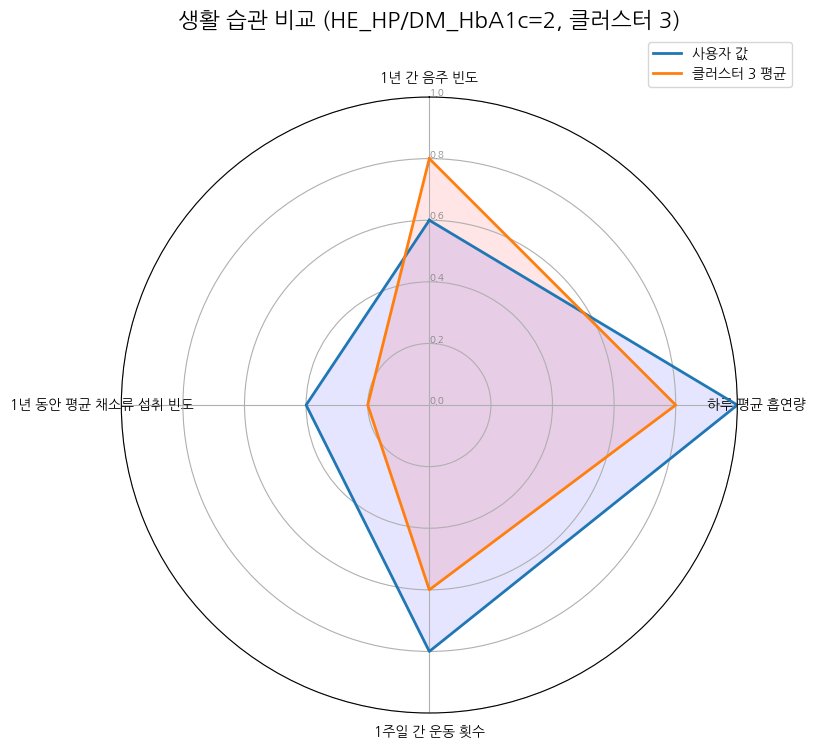

In [ ]:
# lifestyle_comparison.py

import numpy as np
import pandas as pd
# QuantileTransformer를 사용하기 위해 sklearn.preprocessing에서 임포트합니다.
from sklearn.preprocessing import StandardScaler, QuantileTransformer
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from math import sqrt
import matplotlib.font_manager as fm # Import font_manager

# --- Matplotlib에서 한글 출력을 위한 설정 (Google Colab 환경 고려) ---
# Google Colab에서 나눔 폰트 설치 및 캐시 업데이트
# 이 셀은 Google Colab에서 한 번만 실행하면 됩니다.
# 로컬 환경에서는 시스템에 나눔 폰트가 설치되어 있는지 확인하고 아래 설정만 적용하세요.
print("Checking for Korean font installation and setting up matplotlib...")
try:
    # Colab 환경에서 폰트 설치 (로컬에서는 필요 없을 수 있습니다)
    # 설치 후 런타임을 다시 시작해야 폰트가 적용됩니다.
    # !sudo apt-get install -y fonts-nanum
    # !sudo fc-cache -fv

    # 설치된 나눔 글꼴 중 하나를 사용합니다. 시스템에 따라 경로 또는 이름이 다를 수 있습니다.
    # 정확한 폰트 이름을 확인하려면 아래 '사용 가능한 글꼴 목록 출력' 코드를 사용하세요.
    plt.rcParams['font.family'] = 'NanumGothic' # 예시: 나눔고딕
    plt.rcParams['axes.unicode_minus'] = False # 마이너스 기호 깨짐 방지
    print("Matplotlib 'NanumGothic' font set for Korean display.")

except Exception as e:
    print(f"Warning: Could not set NanumGothic font directly: {e}")
    print("Attempting to find a suitable Korean font...")
    try:
        # 사용 가능한 글꼴 목록에서 나눔 또는 맑은 고딕 찾기
        font_list = fm.findSystemFonts(fontpaths=None, fontext='ttf')
        korean_fonts = [f.name for f in fm.fontManager.ttflist if 'Nanum' in f.name or 'Malgun' in f.name or 'Gothic' in f.name or 'Dotum' in f.name]

        if korean_fonts:
            plt.rcParams['font.family'] = korean_fonts[0] # 찾은 첫 번째 한글 폰트 사용
            plt.rcParams['axes.unicode_minus'] = False # 마이너스 기호 깨짐 방지
            print(f"Matplotlib font set to '{korean_fonts[0]}' for Korean display.")
        else:
            print("Warning: No suitable Korean font found on the system.")
            print("Please install a Korean font (e.g., NanumGothic) and ensure matplotlib can find it.")

    except Exception as e2:
        print(f"Severe Warning: Error during fallback font setting: {e2}")
        print("Korean characters may not display correctly.")


# Simulated cluster averages for HE_HP=2, k=5 (derived from previous clustering results)
# In a real application, these should be computed from your clustering results
# Ensure these match the actual cluster means you obtained for HE_HP=2, k=5
cluster_averages = {
    0: {'BD1_11': 15.765957, 'tobacco': 0.351064, 'BE5_1': 0.187943, 'LS_VEG1': 644.741135},
    1: {'BD1_11': 201.724138, 'tobacco': 2.091954, 'BE5_1': 0.505747, 'LS_VEG1': 849.264368},
    2: {'BD1_11': 32.167832, 'tobacco': 1.398601, 'BE5_1': 4.223776, 'LS_VEG1': 907.209790},
    3: {'BD1_11': 61.858824, 'tobacco': 17.658824, 'BE5_1': 0.670588, 'LS_VEG1': 762.941176},
    4: {'BD1_11': 8.715789, 'tobacco': 0.133333, 'BE5_1': 0.168421, 'LS_VEG1': 1095.000000}
}

# Simulated scaler parameters (mean and scale for StandardScaler) for HE_HP=2 group
# In a real application, you would fit a StandardScaler on the HE_HP=2 data and get these values.
# These are example values and might not perfectly match your actual data's mean/scale.
scaler_params = {
    'BD1_11': {'mean': 64.05, 'scale': 72.12}, # Example mean/scale for BD1_11 in HE_HP=2 group
    'tobacco': {'mean': 4.33, 'scale': 7.89}, # Example mean/scale for tobacco in HE_HP=2 group
    'BE5_1': {'mean': 1.15, 'scale': 1.65},   # Example mean/scale for BE5_1 in HE_HP=2 group
    'LS_VEG1': {'mean': 855.80, 'scale': 150.34} # Example mean/scale for LS_VEG1 in HE_HP=2 group
}


# Features used for clustering and radar chart
features = ['BD1_11', 'tobacco', 'BE5_1', 'LS_VEG1']
# Korean labels for radar chart axes
radar_labels = ['1년 간 음주 빈도', '하루 평균 흡연량', '1주일 간 운동 횟수', '1년 동안 평균 채소류 섭취 빈도']


# Function to standardize data using pre-calculated mean and scale
def standardize(value, mean, scale):
    # Handle potential division by zero if scale is 0
    if scale == 0:
        return (value - mean) # Or return 0, or handle as appropriate for your data
    return (value - mean) / scale

# Function to predict cluster (simplified distance-based clustering on scaled data)
def predict_cluster(user_data, cluster_averages, scaler_params, features):
    """
    Predicts the cluster for a user based on their data and pre-calculated cluster averages.
    Uses Euclidean distance on standardized features.

    Args:
        user_data (dict): Dictionary with user's feature values (original scale).
        cluster_averages (dict): Dictionary of cluster averages (original scale).
        scaler_params (dict): Dictionary of mean and scale for standardization.
        features (list): List of feature names to use.

    Returns:
        int: The predicted cluster label.
    """
    # Standardize user data using the pre-calculated parameters
    scaled_user_data = {}
    for f in features:
        if f in user_data and f in scaler_params:
            scaled_user_data[f] = standardize(user_data[f], scaler_params[f]['mean'], scaler_params[f]['scale'])
        else:
            print(f"Warning: Feature '{f}' missing in user_data or scaler_params. Cannot standardize.")
            scaled_user_data[f] = np.nan # Assign NaN if data is missing

    # Calculate distance to each cluster average (on scaled data)
    min_distance = float('inf')
    predicted_cluster = -1 # Default to -1 if no valid cluster found

    for cluster_id, avg_data in cluster_averages.items():
        scaled_avg_data = {}
        valid_features = True
        for f in features:
             if f in avg_data and f in scaler_params:
                 scaled_avg_data[f] = standardize(avg_data[f], scaler_params[f]['mean'], scaler_params[f]['scale'])
             else:
                 print(f"Warning: Feature '{f}' missing in cluster average data or scaler_params for cluster {cluster_id}.")
                 valid_features = False # Cannot calculate distance for this cluster
                 break # Exit inner loop if features are missing

        if valid_features:
            # Calculate Euclidean distance, ignoring NaN values if any
            distance = np.sqrt(np.nansum([(scaled_user_data.get(f, np.nan) - scaled_avg_data.get(f, np.nan))**2 for f in features]))

            if distance < min_distance:
                min_distance = distance
                predicted_cluster = cluster_id

    if predicted_cluster == -1:
        print("Error: Could not predict cluster. Check data and scaler parameters.")
        # You might want to raise an error or handle this case appropriately
        predicted_cluster = 0 # Assign to default cluster 0 as a fallback

    return predicted_cluster


# Function to generate radar chart
def generate_radar_chart(user_data, cluster_id, cluster_averages, features, radar_labels):
    """
    Generates a radar chart comparing user data to the average of their assigned cluster.
    Uses Quantile Scaling for visualization.

    Args:
        user_data (dict): Dictionary with user's feature values (original scale).
        cluster_id (int): The cluster label assigned to the user.
        cluster_averages (dict): Dictionary of cluster averages (original scale).
        features (list): List of feature names to use.
        radar_labels (list): List of corresponding Korean labels for radar chart axes.
    """
    if cluster_id not in cluster_averages:
        print(f"Error: Cluster ID {cluster_id} not found in cluster_averages.")
        return

    # Get cluster averages for the assigned cluster
    cluster_avg = cluster_averages[cluster_id]

    # Prepare data for Quantile Scaling
    # Combine user data and all cluster averages for fitting the scaler
    # This provides a broader distribution for scaling
    all_data_for_scaling = pd.DataFrame([user_data] + list(cluster_averages.values()))[features]
    all_data_for_scaling_clean = all_data_for_scaling.dropna()


    if all_data_for_scaling_clean.shape[0] > 1 and np.unique(all_data_for_scaling_clean.values).shape[0] > 1:
        # Fit QuantileTransformer on the combined data
        scaler_viz = QuantileTransformer(output_distribution='uniform', n_quantiles=max(2, all_data_for_scaling_clean.shape[0]))
        scaler_viz.fit(all_data_for_scaling_clean)

        # Transform user data and cluster average data using the fitted scaler
        # Handle potential NaNs during transformation
        user_values_scaled = scaler_viz.transform(pd.DataFrame([user_data])[features].values)[0]
        cluster_values_scaled = scaler_viz.transform(pd.DataFrame([cluster_avg])[features].values)[0]

    else:
        print("Warning: Not enough data to apply Quantile Scaling for visualization. Using 0.5 for all values.")
        user_values_scaled = np.full(len(features), 0.5, dtype=float)
        cluster_values_scaled = np.full(len(features), 0.5, dtype=float)


    # Number of variables
    N = len(features)

    # Compute angles for each axis
    angles = [n / float(N) * 2 * np.pi for n in range(N)]
    angles += angles[:1]  # Complete the loop

    # Make the plot
    fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))
    ax.set_theta_offset(np.pi / 2)
    ax.set_theta_direction(-1)

    # Draw one axe per variable and add labels
    plt.xticks(angles[:-1], radar_labels)
    ax.set_rlabel_position(0)
    # Set y-ticks for the 0-1 scaled range
    plt.yticks(np.linspace(0, 1, 6), [f"{y:.1f}" for y in np.linspace(0, 1, 6)], color="grey", size=7)
    plt.ylim(0, 1) # Set radial limit to 0-1

    # Plot user data
    values = list(user_values_scaled) + [user_values_scaled[0]]
    ax.plot(angles, values, linewidth=2, linestyle='solid', label='사용자 값') # Updated label
    ax.fill(angles, values, 'b', alpha=0.1)

    # Plot cluster average
    values = list(cluster_values_scaled) + [cluster_values_scaled[0]]
    ax.plot(angles, values, linewidth=2, linestyle='solid', label=f'클러스터 {cluster_id} 평균') # Updated label
    ax.fill(angles, values, 'r', alpha=0.1)

    # Add a title
    # Assuming user_data includes 'HE_HP' or 'HE_DM_HbA1c'
    health_status = user_data.get('HE_HP', user_data.get('HE_DM_HbA1c', 'N/A'))
    plt.title(f'생활 습관 비교 (HE_HP/DM_HbA1c={health_status}, 클러스터 {cluster_id})', size=16, color='black', y=1.1) # Updated title

    # Add a legend
    plt.legend(loc='upper right', bbox_to_anchor=(1.1, 1.1)) # Adjusted legend position

    # Show the plot
    plt.show()

# Main function to get user input and run the comparison
def main():
    print("생활 습관 비교 서비스")
    print("생활 습관 데이터를 입력하세요:")

    # Get user input
    try:
        # Use raw input to allow empty strings for default values
        bd1_11_input = input("1년 간 음주 빈도 (0-286, 기본값 50): ")
        tobacco_input = input("하루 평균 흡연량 (0-999, 기본값 5): ")
        be5_1_input = input("1주일 간 운동 횟수 (0-5, 기본값 3): ")
        ls_veg1_input = input("1년 동안 평균 채소류 섭취 빈도 (0-1095, 기본값 800): ")
        # Assuming HE_HP is used based on the provided cluster averages
        he_hp_input = input("고혈압 단계 (1-4, 기본값 2): ")


        # Convert input to float/int, using defaults if input is empty
        bd1_11 = float(bd1_11_input) if bd1_11_input else 50.0
        tobacco = float(tobacco_input) if tobacco_input else 5.0
        be5_1 = float(be5_1_input) if be5_1_input else 3.0
        ls_veg1 = float(ls_veg1_input) if ls_veg1_input else 800.0
        he_hp = int(he_hp_input) if he_hp_input else 2

        # Validate input ranges (simplified for this example)
        # In a real app, more robust validation is needed
        if not (0 <= bd1_11 <= 286 and 0 <= tobacco <= 999 and 0 <= be5_1 <= 5 and 0 <= ls_veg1 <= 1095 and 1 <= he_hp <= 4):
             print("Warning: Input values are outside typical ranges. Proceeding anyway.")


        # This demo is specifically for HE_HP=2 based on the simulated cluster averages
        if he_hp != 2:
             print("Warning: This demo is based on HE_HP=2 clustering results. Proceeding with HE_HP=2 for prediction.")
             he_hp = 2


        user_data = {
            'BD1_11': bd1_11,
            'tobacco': tobacco,
            'BE5_1': be5_1,
            'LS_VEG1': ls_veg1,
            'HE_HP': he_hp # Include HE_HP in user_data for the title
        }

        # Predict cluster using the simplified function
        # Note: This prediction is based on simulated data and scaler parameters.
        # In a real application, you would use a trained model and scaler from your actual clustering process.
        predicted_cluster = predict_cluster(user_data, cluster_averages, scaler_params, features)
        print(f"사용자님은 클러스터 {predicted_cluster}에 속할 것으로 예측됩니다 (HE_HP={user_data['HE_HP']}).")

        # Generate radar chart
        generate_radar_chart(user_data, predicted_cluster, cluster_averages, features, radar_labels)

    except ValueError as e:
        print(f"오류: 유효한 숫자 값을 입력하세요. {e}")
    except Exception as e:
        print(f"예기치 않은 오류 발생: {e}")


if __name__ == "__main__":
    main()


In [40]:
from sklearn.preprocessing import MinMaxScaler
import pandas as pd

# 사용할 컬럼들만 추출
features = ['BE5_1', 'LS_VEG1', 'tobacco', 'BD1_11']
score_df = df[features].copy()

# 결측치 제거 또는 채움 (간단 예시로 0으로 대체)
score_df = score_df.fillna(0)

# 정규화: 운동/채소(높을수록 좋음), 흡연/음주(낮을수록 좋음 → 역정규화)
scaler = MinMaxScaler()

# 정규화된 값 구하기
score_df[['BE5_1_norm', 'LS_VEG1_norm']] = scaler.fit_transform(score_df[['BE5_1', 'LS_VEG1']])
score_df[['TOBACCO_norm', 'BD1_11_norm']] = scaler.fit_transform(score_df[['tobacco', 'BD1_11']])

# TOBACCO, BD1_11은 낮을수록 좋으므로 (1 - 정규화된 값)
score_df['TOBACCO_score'] = 1 - score_df['TOBACCO_norm']
score_df['BD1_11_score'] = 1 - score_df['BD1_11_norm']

# Lifestyle Score 계산: 단순 평균 (가중치 필요 시 곱셈 가능)
score_df['Lifestyle_Score'] = score_df[['BE5_1_norm', 'LS_VEG1_norm', 'TOBACCO_score', 'BD1_11_score']].mean(axis=1)
# 가중치를 적용한 Lifestyle Score 계산


# 원래 DF에 병합
df['Lifestyle_Score'] = score_df['Lifestyle_Score']


In [41]:
df['Lifestyle_Score']

0        0.666667
1        0.906177
2        0.879953
3        0.739510
4        0.894755
           ...   
13189    0.739510
13190    0.944755
13191    0.656177
13192    0.989510
13193    0.354167
Name: Lifestyle_Score, Length: 13194, dtype: float64

그래프

In [10]:
data = pd.read_csv("건강데이터_2022_2023_합본.csv")

In [ ]:
# HE_DM_HbA1c
if 'HE_DM_HbA1c' in data.columns:
    data['HE_DM_HbA1c'] = data['HE_DM_HbA1c'].replace([9, 99, 999, 888, 9.0, 99.0, 999.0, 888.0], np.nan)
    if 'DE1_dg' in data.columns:
        print(f"DE1_dg missing ratio: {data['DE1_dg'].isnull().mean()}")
        data['HE_DM_HbA1c'] = data['HE_DM_HbA1c'].fillna(data['DE1_dg'].map({0: 1, 1: 3}))
    # 남은 결측치는 드랍랍
    if data['HE_DM_HbA1c'].isnull().any():
        data = data[data['HE_DM_HbA1c'].notnull()]
    print(f"HE_DM_HbA1c NaN count after: {data['HE_DM_HbA1c'].isnull().sum()}")
# HE_obe
if 'HE_obe' in data.columns:
    data['HE_obe'] = data['HE_obe'].replace([9, 99, 999, 888, 9.0, 99.0, 999.0, 888.0], np.nan)
    if 'HE_BMI' in data.columns:
        # BMI가 KNN 대체된 경우 표시
        data['HE_BMI_imputed'] = data['HE_BMI'].isnull().astype(int)
        data['HE_obe'] = data.apply(
            lambda row: row['HE_obe'] if pd.notna(row['HE_obe']) else (
                1 if row['HE_BMI'] < 18.5 else
                2 if row['HE_BMI'] < 25 else
                3 if row['HE_BMI'] < 30 else
                4 if row['HE_BMI'] < 35 else
                5 if row['HE_BMI'] < 40 else
                6
            ),
            axis=1
        )
    # 남은 결측치는 드랍
    if data['HE_obe'].isnull().any():
        data = data[data['HE_obe'].notnull()]
    print(f"HE_obe NaN count after: {data['HE_obe'].isnull().sum()}")
# HE_HP
if 'HE_HP' in data.columns:
    data['HE_HP'] = data['HE_HP'].replace([9, 99, 999, 888, 9.0, 99.0, 999.0, 888.0], np.nan)
    if 'DI1_dg' in data.columns:
        print(f"DI1_dg missing ratio: {data['DI1_dg'].isnull().mean()}")
        data['HE_HP'] = data['HE_HP'].fillna(data['DI1_dg'].map({0: 1, 1: 4}))
    # 남은 결측치는 드랍랍
    if data['HE_HP'].isnull().any():
        data = data[data['HE_HP'].notnull()]
    print(f"HE_HP NaN count after: {data['HE_HP'].isnull().sum()}")
#결측치 비율 낮은 변수 처리
# low_missing_columns = [
#     'DI1_dg',
#     'DE1_dg',
# ]
continuous_columns = ['HE_wt', 'HE_ht', 'HE_BMI']  # 연속형 변수
#for col in low_missing_columns + continuous_columns:
for col in continuous_columns:
    if col in data.columns:
        data[col] = pd.to_numeric(data[col], errors='coerce')
        data[col] = data[col].replace([9, 99, 999, 88, 888, 9.0, 99.0, 999.0, 88.0, 888.0], np.nan)
        if not data[col].isnull().all():
            if col in continuous_columns:
                median_value = data[col].median()
                data[col] = data[col].fillna(median_value)
                print(f"Median for {col}: {median_value}")
            else:
                mode_series = data[col].mode(dropna=True)
                if not mode_series.empty:
                    mode_value = mode_series[0]
                    data[col] = data[col].fillna(mode_value)
                    print(f"Mode for {col}: {mode_value}")
                else:
                    print(f"No valid mode for {col}, leaving as is.")
        else:
            print(f"Column {col} is all NaN, skipping.")



DE1_dg missing ratio: 0.0006821282401091405
HE_DM_HbA1c NaN count after: 0
HE_obe NaN count after: 0
DI1_dg missing ratio: 0.0
HE_HP NaN count after: 0
Median for HE_wt: 62.7
Median for HE_ht: 163.0
Median for HE_BMI: 23.744212501361336


In [12]:
# 일반 담배 하루 평균 흡연량 처리
data['BS3_2'] = data['BS3_2'].replace(888, 0)

# 전자 담배 하루 평균 흡연량 처리
data['BS12_47_1'] = data['BS12_47_1'].replace({888: 0, 999: np.nan}) 

# 합치기 전 숫자형으로 변환
data['BS3_2'] = pd.to_numeric(data['BS3_2'], errors='coerce')
data['BS12_47_1'] = pd.to_numeric(data['BS12_47_1'], errors='coerce')

# 두 변수 합산 (NaN은 무시하고 합함)
data['tobacco'] = data[['BS3_2', 'BS12_47_1']].sum(axis=1, skipna=True)

data['tobacco'] = data['tobacco'].astype(str).str.strip().replace({  
'999.0': np.nan,
})

data['tobacco'] = pd.to_numeric(data['tobacco'], errors='coerce')

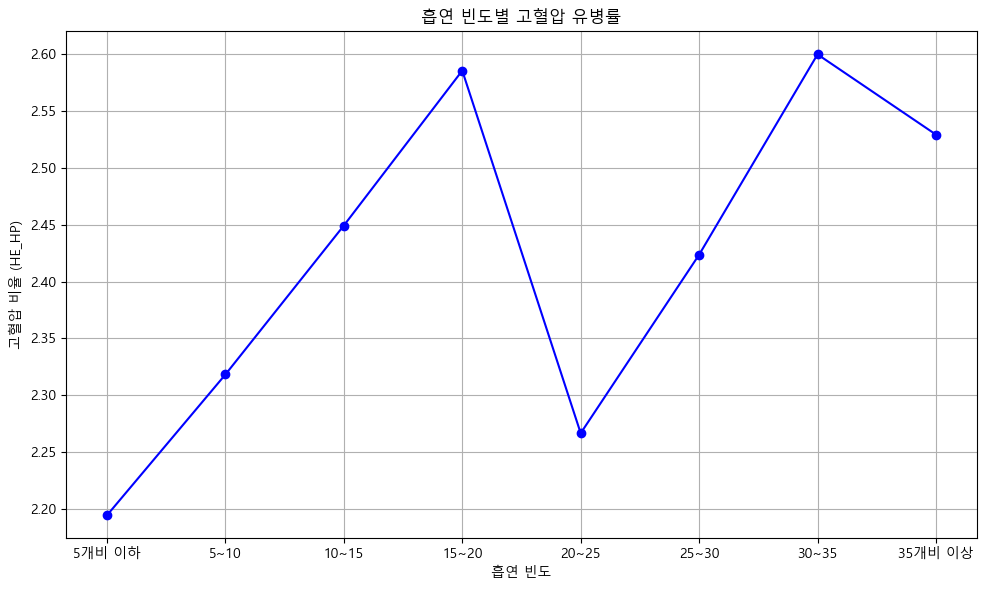

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
# 1. 나이 그룹 생성 (AGE_GROUP 컬럼 추가)
bins = [0, 5, 10, 15, 20, 25, 30, 35, 40]  # 80세 이상 포함
labels = ['5개비 이하', '5~10', '10~15', '15~20', '20~25', '25~30', '30~35', '35개비 이상']

data['tobacco_GROUP'] = pd.cut(data['tobacco'], bins=bins, labels=labels, right=True)
# 2. 나이그룹별 당뇨병 평균값(= 유병률) 계산
group_stats = data.groupby('tobacco_GROUP')['HE_HP'].mean().reset_index()
# 3. 시각화
plt.figure(figsize=(10, 6))
plt.plot(group_stats['tobacco_GROUP'], group_stats['HE_HP'], marker='o', color='blue')
plt.xlabel('흡연 빈도')
plt.ylabel('고혈압 비율 (HE_HP)')
plt.title('흡연 빈도별 고혈압 유병률')
plt.grid(True)
plt.tight_layout()
plt.show()

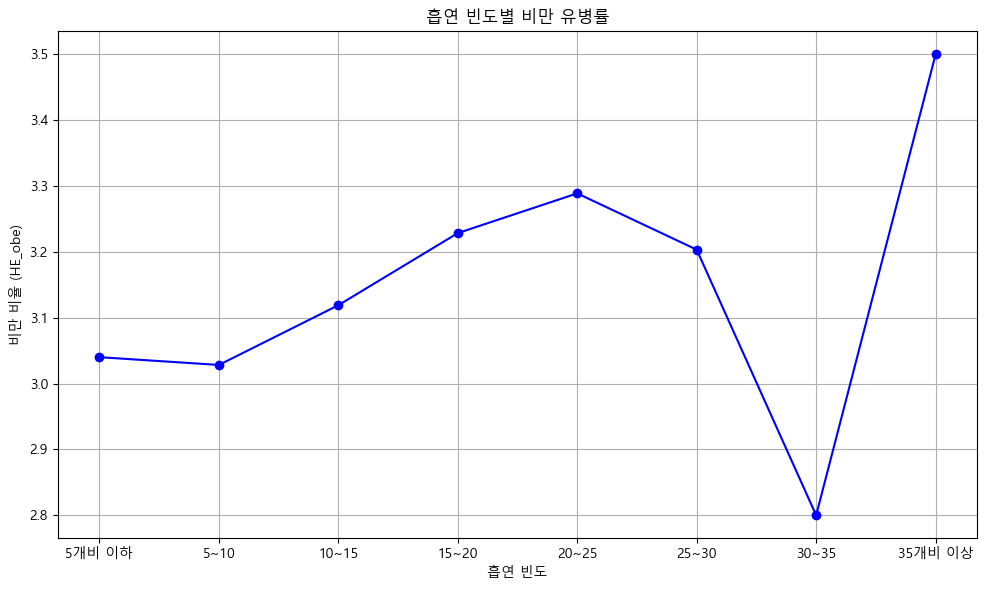

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
# 1. 나이 그룹 생성 (AGE_GROUP 컬럼 추가)
bins = [0, 5, 10, 15, 20, 25, 30, 35, 40]  # 80세 이상 포함
labels = ['5개비 이하', '5~10', '10~15', '15~20', '20~25', '25~30', '30~35', '35개비 이상']

data['tobacco_GROUP'] = pd.cut(data['tobacco'], bins=bins, labels=labels, right=True)
# 2. 나이그룹별 당뇨병 평균값(= 유병률) 계산
group_stats = data.groupby('tobacco_GROUP')['HE_obe'].mean().reset_index()
# 3. 시각화
plt.figure(figsize=(10, 6))
plt.plot(group_stats['tobacco_GROUP'], group_stats['HE_obe'], marker='o', color='blue')
plt.xlabel('흡연 빈도')
plt.ylabel('비만 비율 (HE_obe)')
plt.title('흡연 빈도별 비만 유병률')
plt.grid(True)
plt.tight_layout()
plt.show()

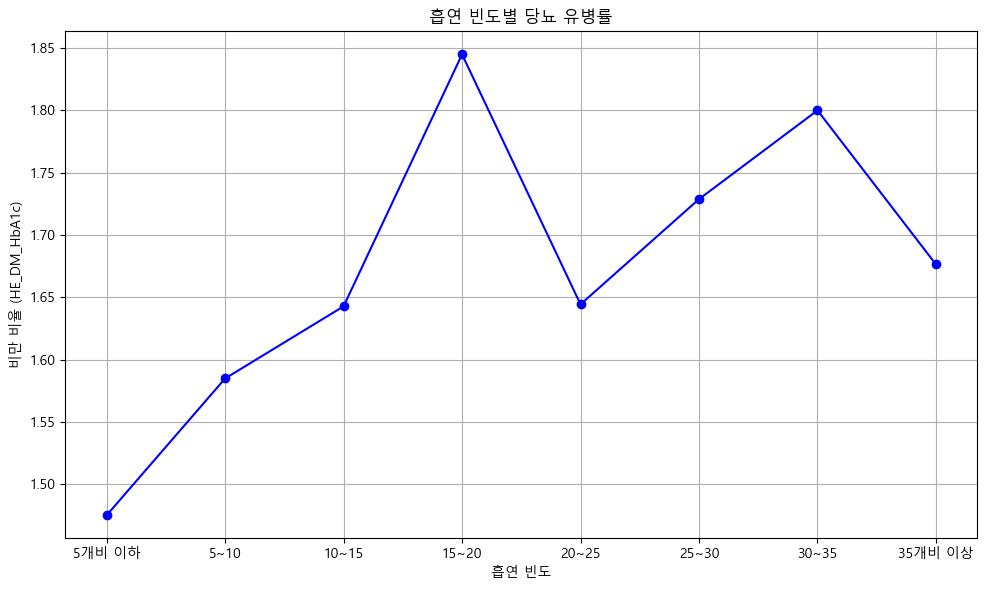

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
# 1. 나이 그룹 생성 (AGE_GROUP 컬럼 추가)
bins = [0, 5, 10, 15, 20, 25, 30, 35, 40]  # 80세 이상 포함
labels = ['5개비 이하', '5~10', '10~15', '15~20', '20~25', '25~30', '30~35', '35개비 이상']

data['tobacco_GROUP'] = pd.cut(data['tobacco'], bins=bins, labels=labels, right=True)
# 2. 나이그룹별 당뇨병 평균값(= 유병률) 계산
group_stats = data.groupby('tobacco_GROUP')['HE_DM_HbA1c'].mean().reset_index()
# 3. 시각화
plt.figure(figsize=(10, 6))
plt.plot(group_stats['tobacco_GROUP'], group_stats['HE_DM_HbA1c'], marker='o', color='blue')
plt.xlabel('흡연 빈도')
plt.ylabel('비만 비율 (HE_DM_HbA1c)')
plt.title('흡연 빈도별 당뇨 유병률')
plt.grid(True)
plt.tight_layout()
plt.show()